# Ames Housing Price Prediction: Machine Learning Project <a id="top"></a>

[Kaggle Link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

[Original Paper](http://jse.amstat.org/v19n3/decock.pdf)

[Neighborhood map](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/maps)

[Zoning map](https://cityofamesgis.maps.arcgis.com/home/webmap/viewer.html?layers=9874ff4f0bc84bfa9e9cb5326b36f3b0)


- [Packages & Data Import](#prep)
- [Feature Exploration](#features)
- [Outlier Removal](#outlier)
- [Multi-Collinearity](#multicolinearity)
- [Data Cleaning & Missing Values](#cleaning)
- [Feature Engineering](#feature_eng)
- [Preprocessing](#preprocessing)
- [Feature Selection](#feature_selection)
- [Model Creation](#modeling)
- [Model Comparison](#compare)
- [Analysis](#analysis)

## Packages <a id='prep'></a>

https://github.com/jupyter/notebook/issues/4980
https://jupyter-notebook.readthedocs.io/en/stable/troubleshooting.html

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


## Data Import

In [103]:
# test and train datasets,
#  Data Description: written description and keys to categorical variables
#  Sample_submission are also included in the kaggle data.
#  
test = pd.DataFrame()
train = pd.DataFrame()
#sample_submission = pd.read_csv("./data/sample_submission.csv")


def custom_import(train_only = False):
    ''' Simple import function to reload data.
    Train_only will return only the Train dataframe
    
    Value:
    If train_only False: tuple of train, test, target
    If train_only True: train dataframe
    '''
    test   = pd.read_csv("./data/test.csv")
    train  = pd.read_csv("./data/train.csv")
    target = train['SalePrice']
    train  = train.drop(labels = ['SalePrice'], axis = 1)

    
    if train_only:
        return train
    else:
        return (train, test, target)

train, test, target = custom_import()

## Feature Exploration <a id='features'></a>

The ames dataset contains 81 features, including an 'ID' and 'Sales Price' (target) column, a mix of categorical and nominal varialbes. Below we describle some of these features using the attached data_description.txt file and consider possible feature engineering.

##### Target Variable

([<matplotlib.axis.XTick at 0x244f0db1310>], [Text(0, 0, '')])

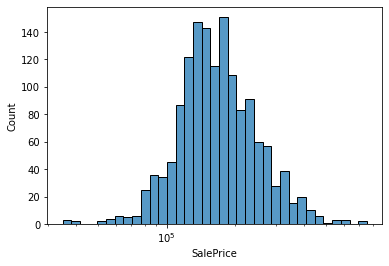

In [3]:
sns.histplot(target,log_scale=True)
#plt.xticks([1000,10000,100000,1000000,10000000])
plt.xticks([100000])

### Eda Plotting and Missingness functions

In [18]:
# Generates a subplot containing all the categorical features
#  numeric features are shunted to jointplot which dont easily support subplots
def eda_plots(cats, nums, data, target, figsize = (20,20), log = False, ylog = True):
    cat_len = len(cats)
    if(cat_len % 2 ==0):
        x = int(cat_len/2)
    else:
        x = int(math.ceil(cat_len/2))
    y = 2
    
    if ylog:
        target = np.log(target)
    else:
        target = target
    
    
    fig, ax = plt.subplots(x,y, figsize = figsize)
    for var, loc in zip(cats,ax.flatten()):
        sns.violinplot(x=data[var], y = target, ax=loc)
        for label in loc.get_xticklabels():
                label.set_rotation(90)
        plt.tight_layout()
    for var in nums:
        if log:
            sns.jointplot(x= np.log(data[var]), y = target, alpha =.1)
        elif not log:
            sns.jointplot(x= data[var], y = target, alpha = .1)
            
            
            
# prints out the column and number of missing values.
def easy_missing(cats, num, data):
    nulls = data[cats+num].isnull().sum(axis =0)
    print("Columns with missing values")
    print(nulls[nulls.values !=0])

### Grouping Features

##### Location Information
- MSZoning: type of zoning
- Street: Type of road access
- Alley: Type of ally access
- Lot Shape: general shape
- LandContour: flatness of property
- LotConfig: how lot relates to street (culdusac, corner, frontage)
- LandSlope: slope, gentle, moderate, severe
- Neighborhood: physical location
- Condition1/2: proximity to conditons (major roads, railroads, parks)


- LotFrontage: linear feet of stread
- LotArea: size in square feet

##### Feature Engineering

- Seems like zoning and neighborhood add a lot to the price
- The spead of lot shape chnages between categories,
- Gravel alleys and Streets have lower log(price) than paved (expected)
- The log of logfrontage and lotArea show a loose correlation with log saleprice.
- Might be worth coding condition1/2 into 9 categorical variables for each condition
- Missingness: Alley: NA = no ally present, might be work recoding into a value ("no_ally")
- missingness: LotFrontage: 

Columns with missing values
Alley          1369
LotFrontage     259
dtype: int64


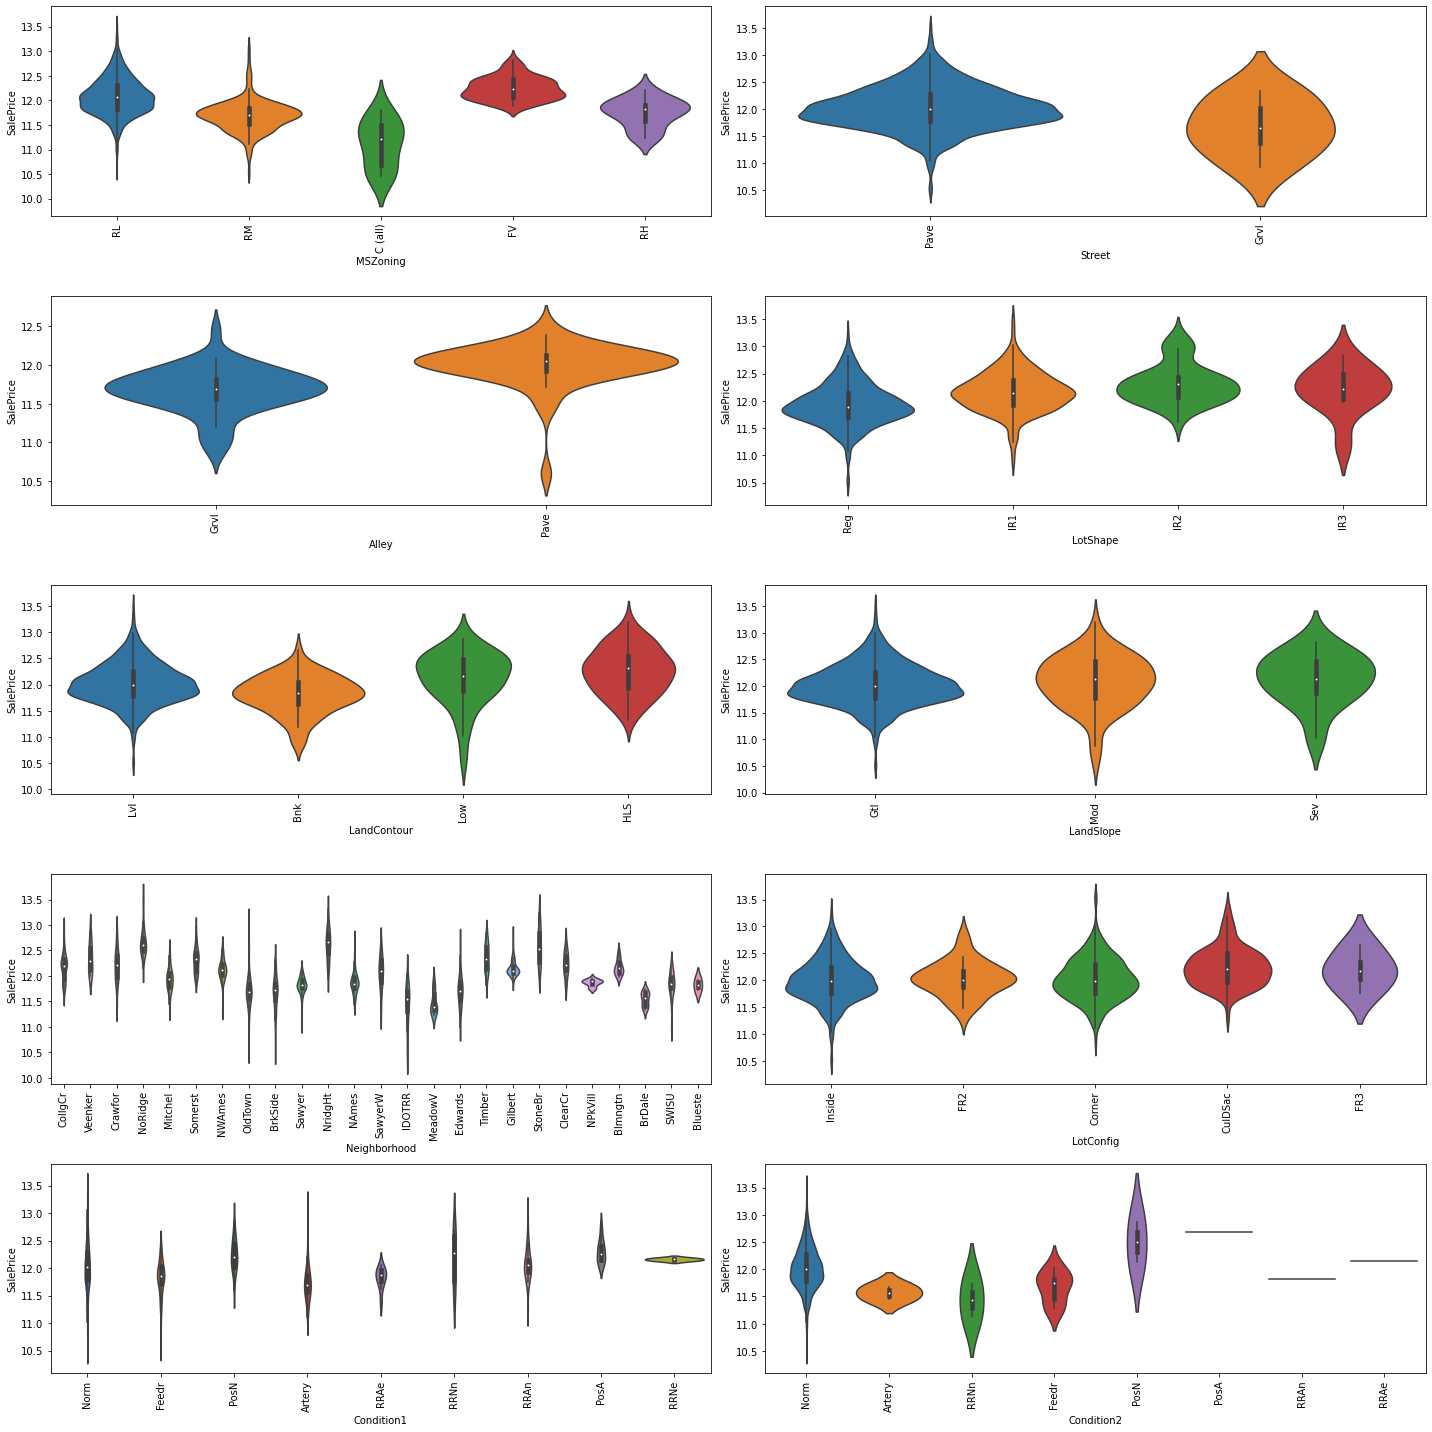

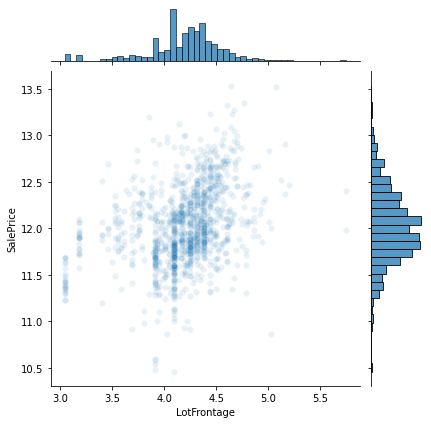

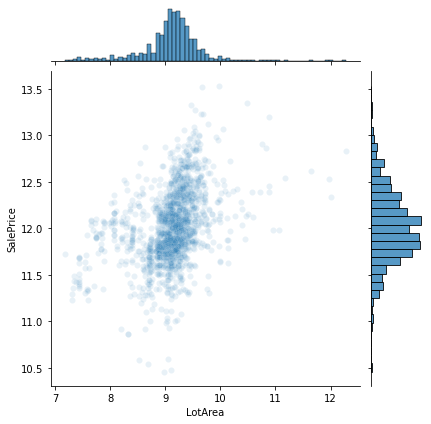

In [19]:
cat_vars = ["MSZoning","Street","Alley","LotShape","LandContour","LandSlope",
            "Neighborhood", "LotConfig",'Condition1','Condition2',]
num_vars = ["LotFrontage","LotArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20),
          log = True)

easy_missing(cat_vars, 
             num_vars, 
             train)

##### House (General and Exterior) Information
- MSSubClass: type of dwelling
- BldgType: type of dwelling
- HouseStyle: style of dwelling
- OverallQual: material and finish: numeric but ordinal.
- OverallCond: condition: numeric but ordinal.
- RoofStyle: roof type
- RoofMatl: roof material
- Exterior1st: exterior covering
- Exterior2nd: exterior covering if more than 1
- MasVnrType: masonry veneer type
- ExterQual: material quaility: ordinal
- ExterCond: conditions of materials: ordinal
- Foundation: type

- Utilities: type avalible
- Heating: type
- Heating QC: ordinal
- CentralAir: yes/no
- Electrical: type of electric: ordinal

- YearBuilt: original construction date
- YearRemodAdd: remodel or addition date (same as yearbuilt if no work done)
- MasVnrArea: masonry veneer in sq feet


##### Feature Engineering:
- overall quality explains a good deal of price but needs to be recoded to categorical.
- It seems overall quality explains more than conditon ( overall , exterior)
- Utilities, heading, electrical, and headtingQC all have a condition with only 1 value. might be an outlier?
- YearBuilt and YearRemodeled proabably need to be reconstructed. year_updated or years_since_update?
- MasVnrArea: might be worth exploring a categorical + numeric (MasVnr T/F, MasVnrArea)
- MSSubClass needs to be recoded as a categorical variable same with Quality and Condition.
- Missingness: Vnrtype and Area should be imputted by most common in neighborhood
- Missingness: Electrical, use most common type. 

Columns with missing values
MasVnrType    8
Electrical    1
MasVnrArea    8
dtype: int64


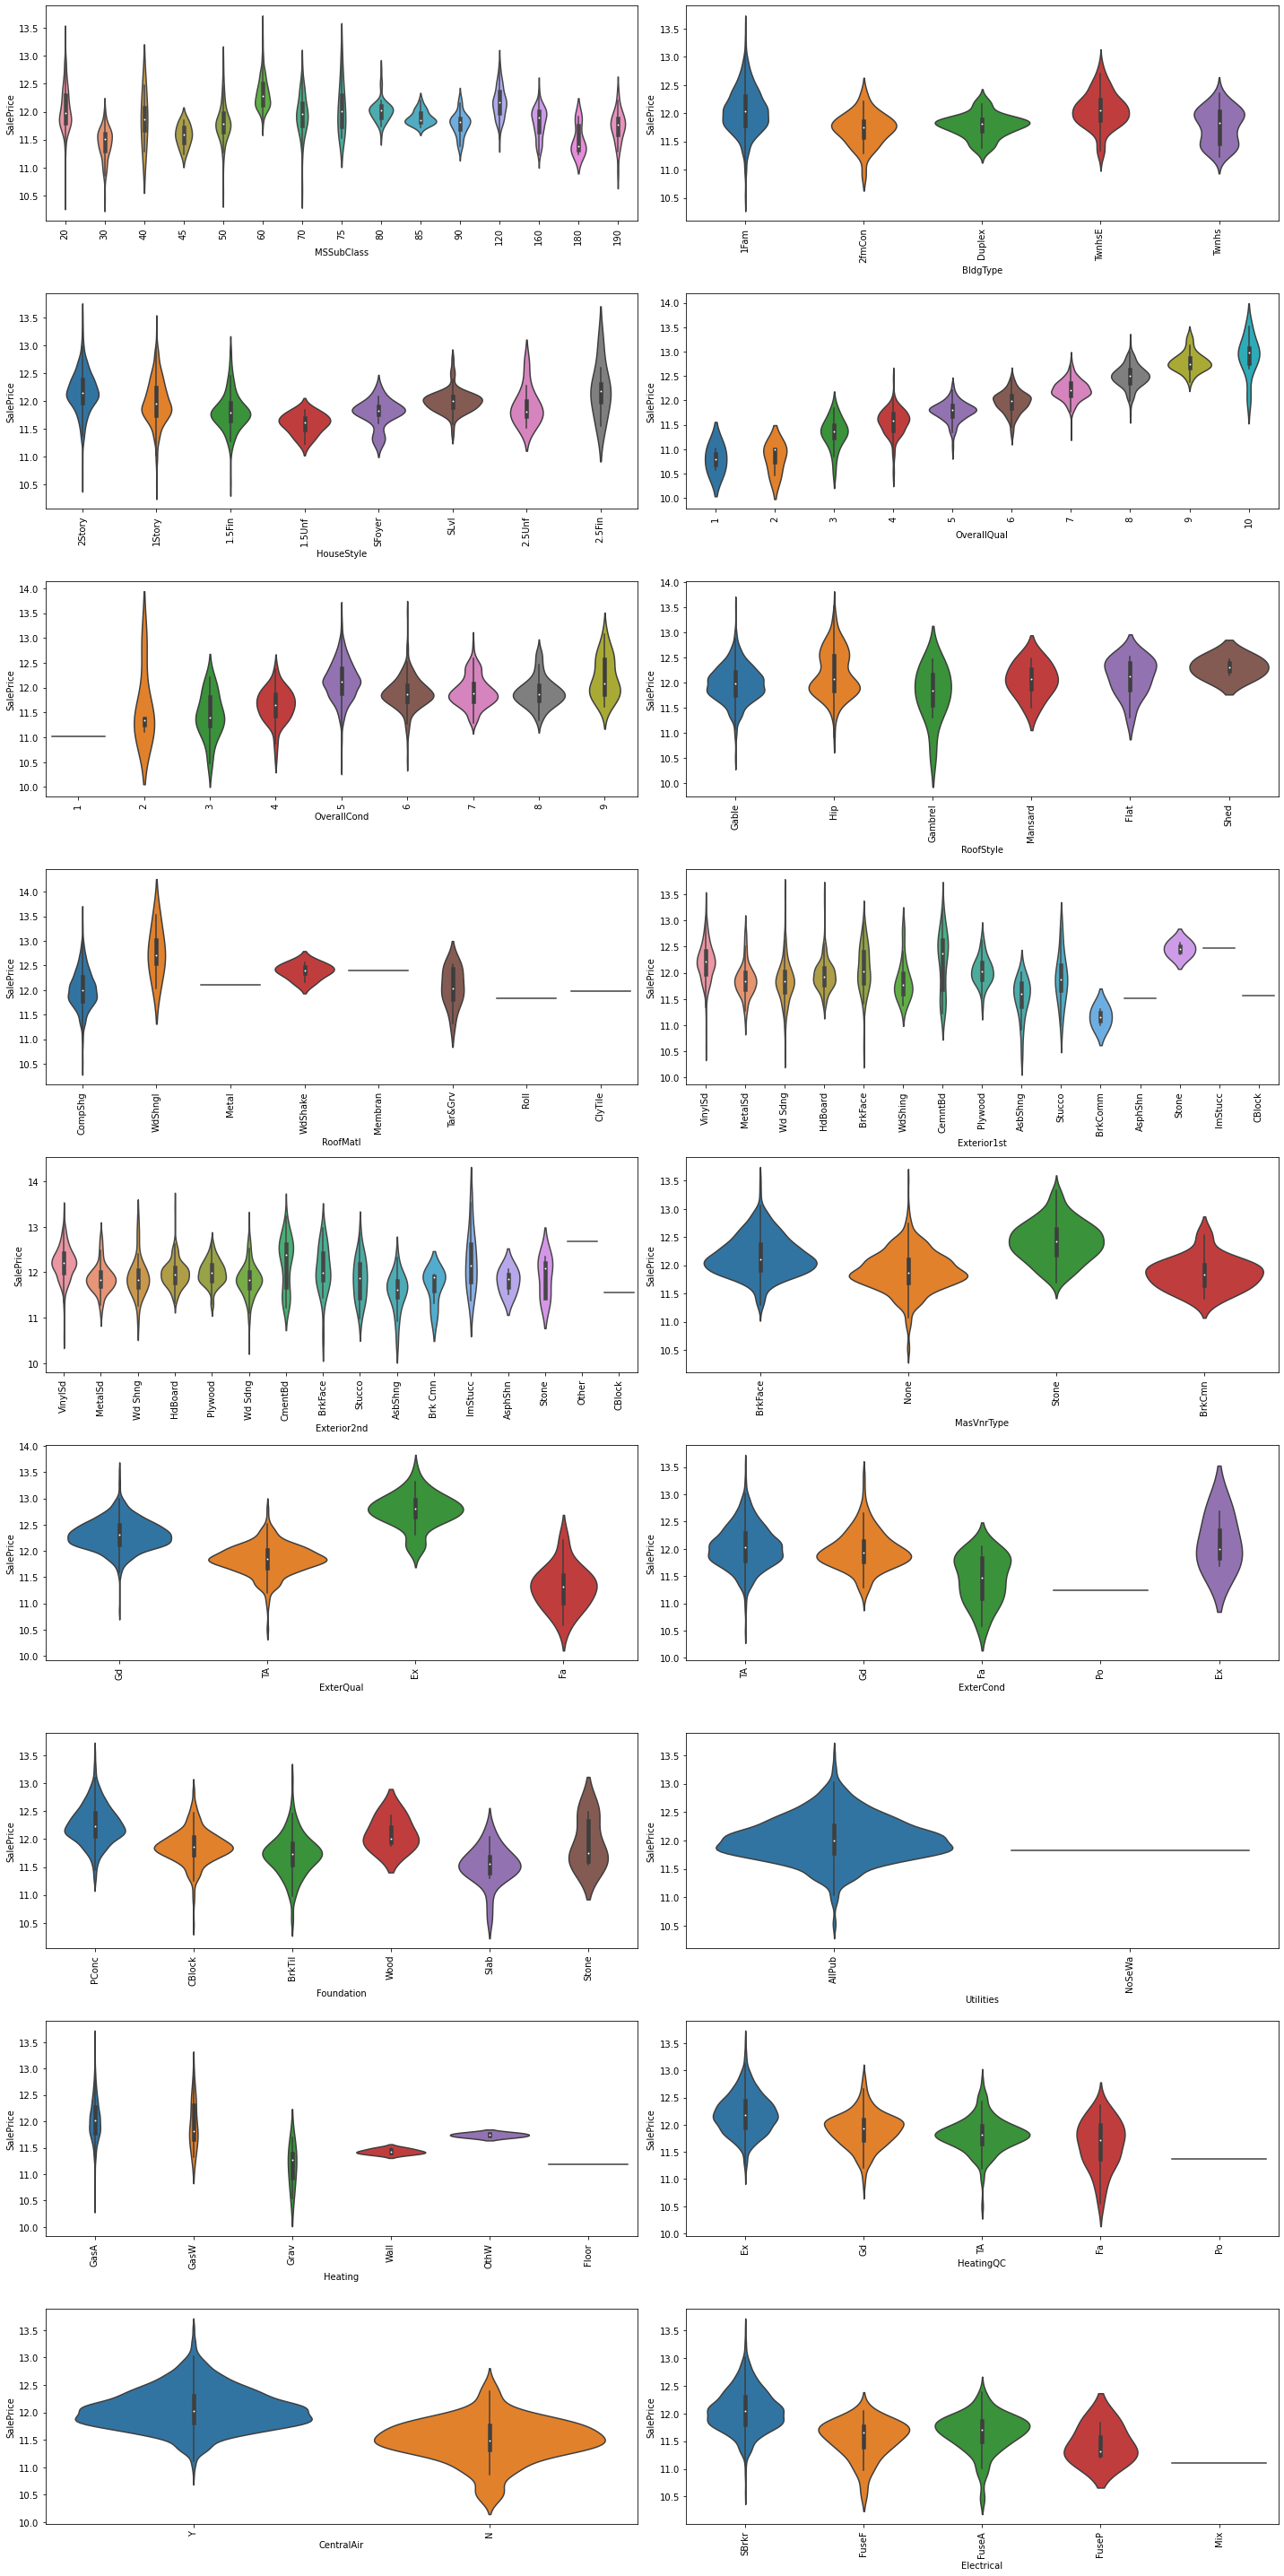

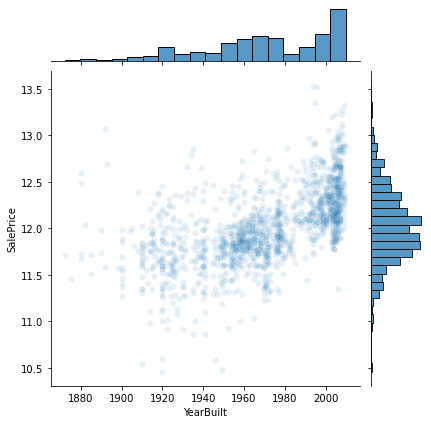

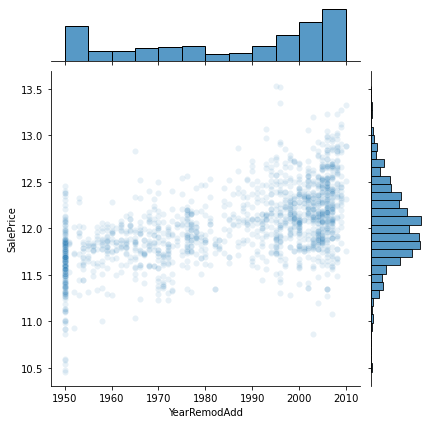

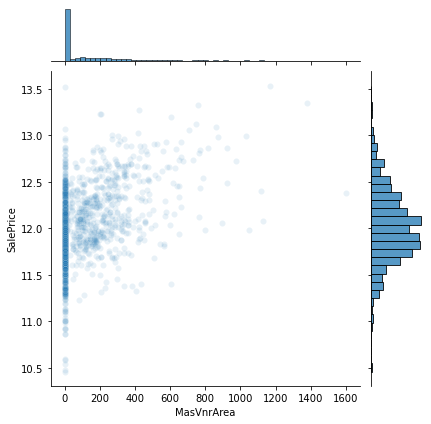

In [20]:
cat_vars = ['MSSubClass','BldgType','HouseStyle','OverallQual','OverallCond',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
                'Utilities','Heating','HeatingQC','CentralAir','Electrical']
num_vars = ['YearBuilt','YearRemodAdd','MasVnrArea']

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,40))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### House (Rooms) Information
- BsmtQual: height of basement: ordinal
- BsmtCond: condition of basement: ordinal
- BsmtExposure: walk out or no outside access
- BsmtFinType1/2: rating of finished area: ordinal
- kitchenQual: kitchen quality: ordinal
- FireplaceQu: fireplace Quality: ordinal

- BsmtFinSF1/2: type 1/2 finished square feet
- BsmtUnfSF: unfinished square feet
- TotalBsmtSF: total basement square feet
- 1stFlrSF: first floor square feet
- 2ndFlrSF: second floor square feet
- LowQualFinSF: low quality finsihed square feet(all floors)
- GrLivArea: above ground living area square feet
- BsmtFullBath: # basement full baths
- BsmtHalfBath: # basement half baths
- FullBath: full baths above ground
- HalfBath: half baths above ground
- Bedroom: bedrooms above ground
- Kitchen: kitchens above ground
- TotRmsAbvGrd: total rooms above grade (not bathrooms)
- Fireplaces: # fireplaces

##### Feature Engineering
- Missingness: All the basement information is likely just mislabeled "no basements"
- Missingness: Fireplace Quality is due to lack of fireplace 
- There doesnt seem to be a big difference between Rec/BLQ/LwQ for BsmtFinType1
- Unfinished Basement SQF doesnt seem to add much
- LowQualFinSF doesnt seem to add anything
- TotalBsmtSF and 1stFlrSF seem to have two groups of distributions.
- Might be worth adding a 'has basement' column
- total_full baths
- total_half baths
- total_baths



Columns with missing values
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
FireplaceQu     690
dtype: int64


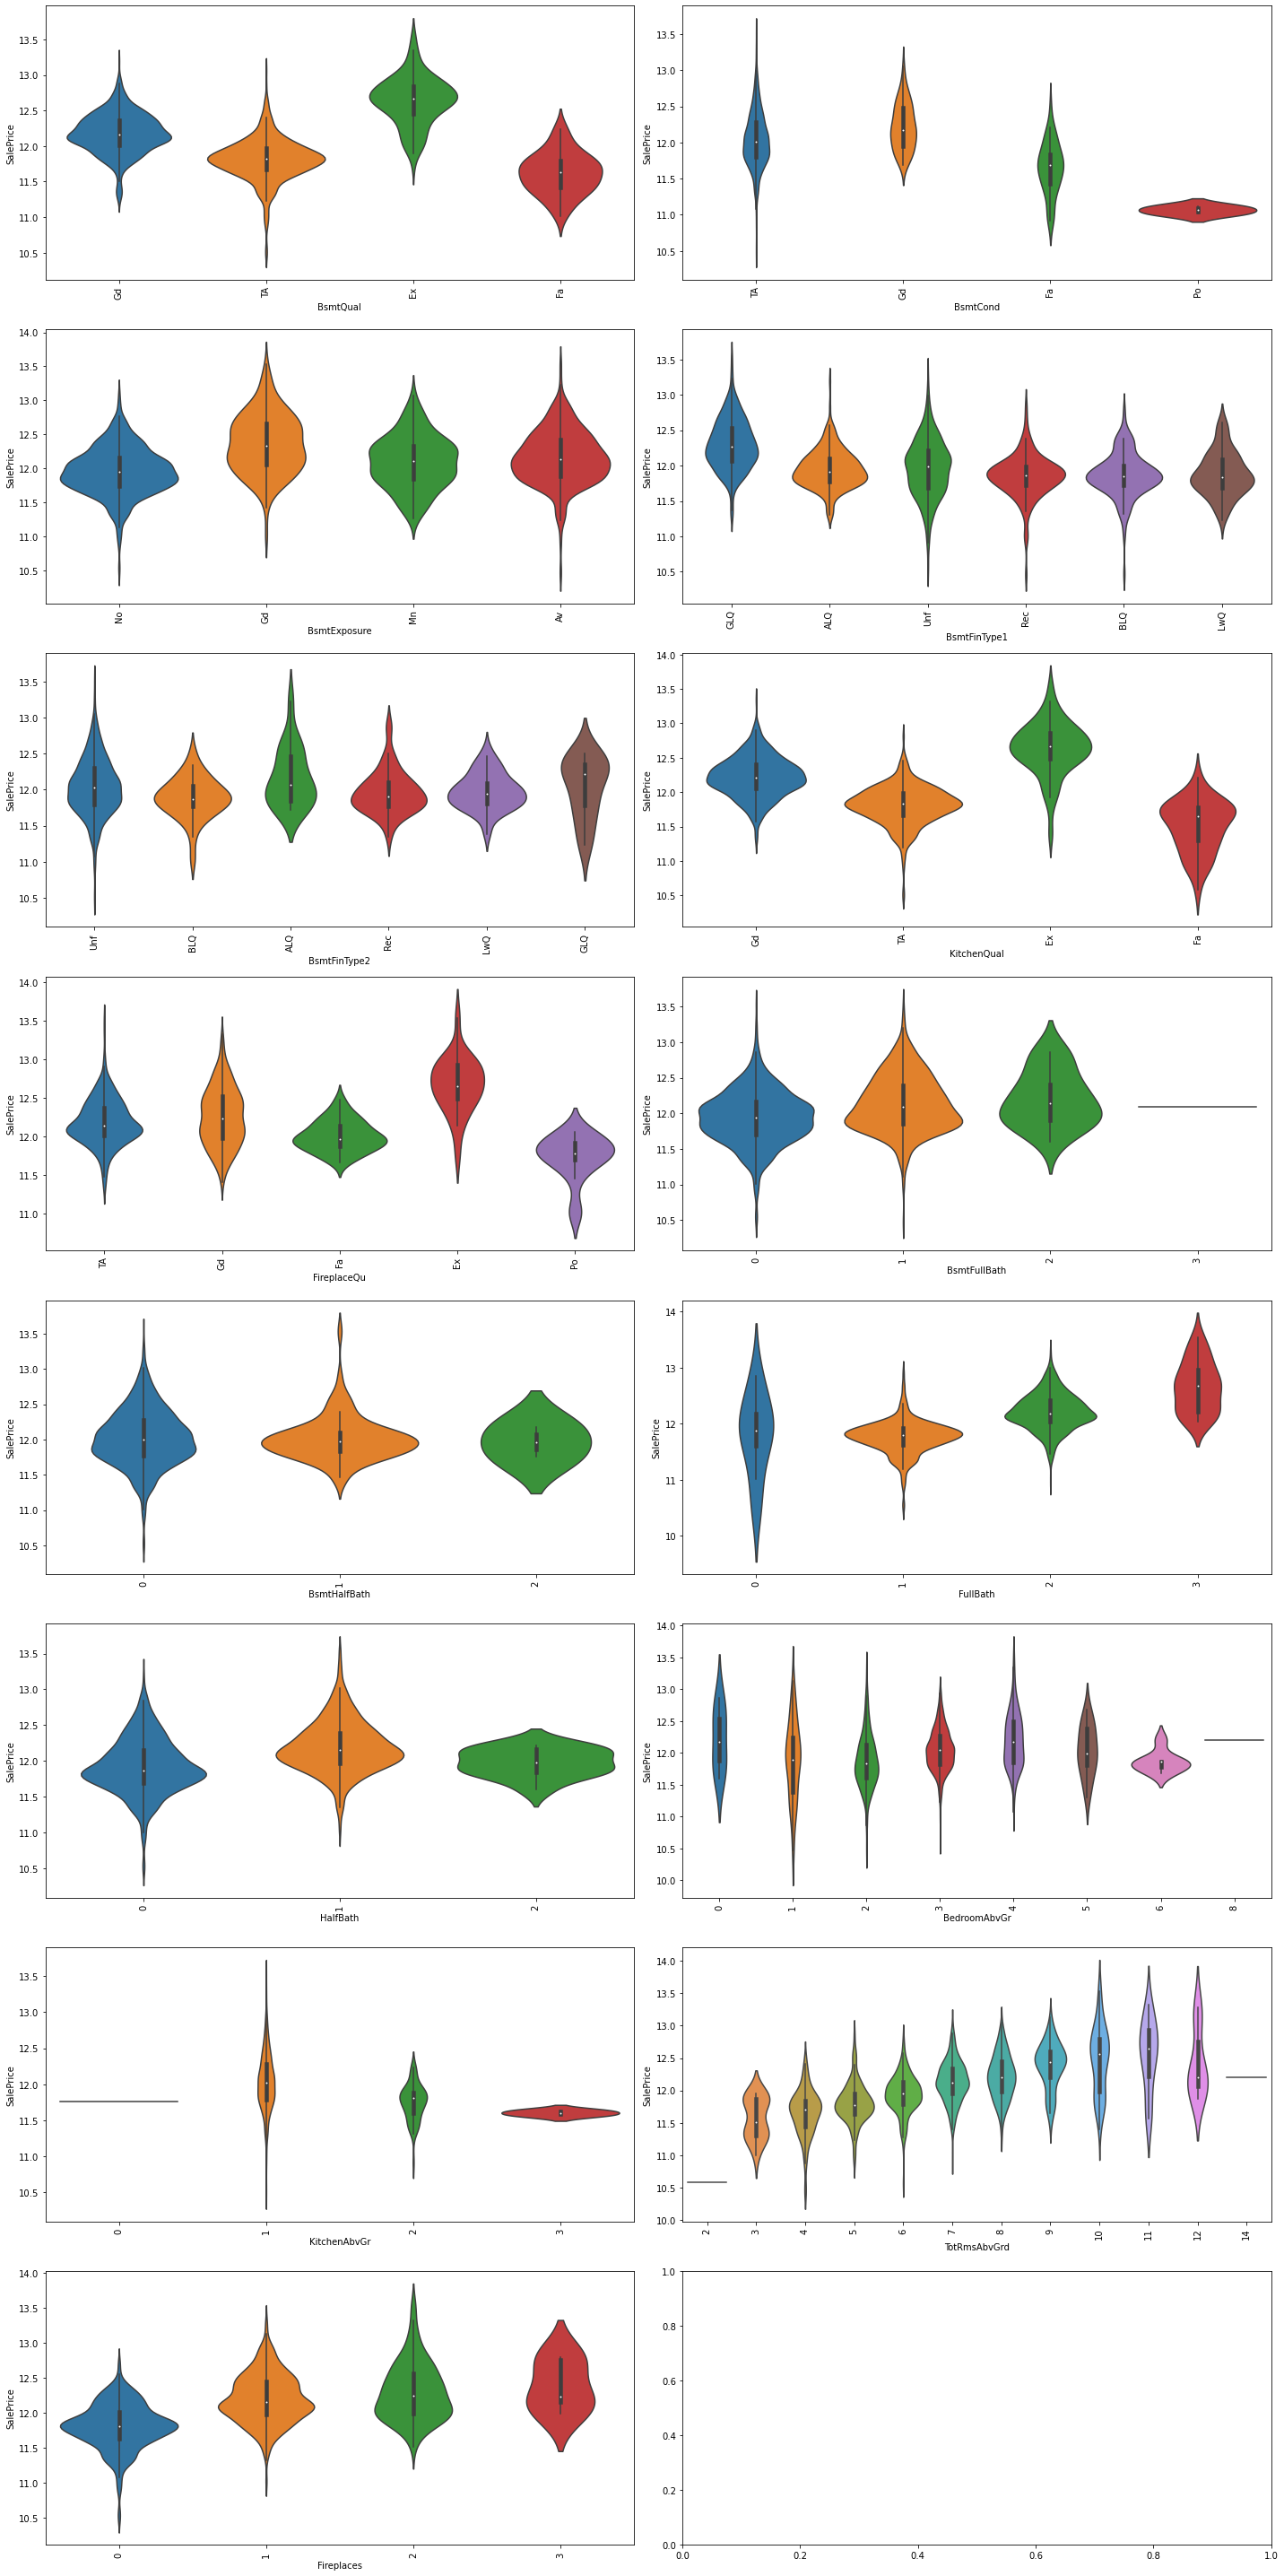

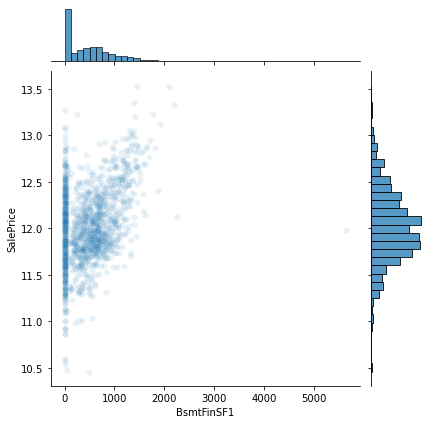

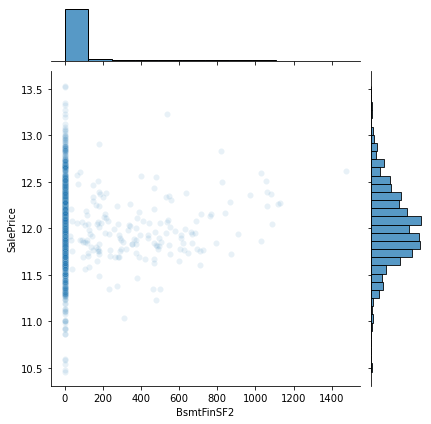

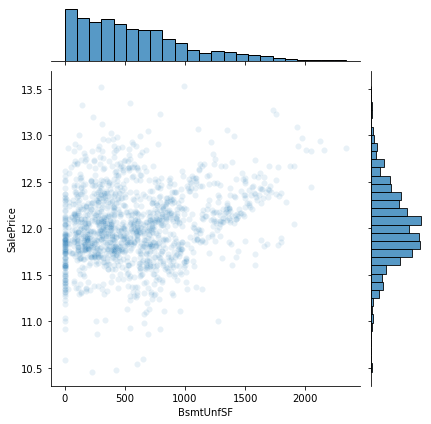

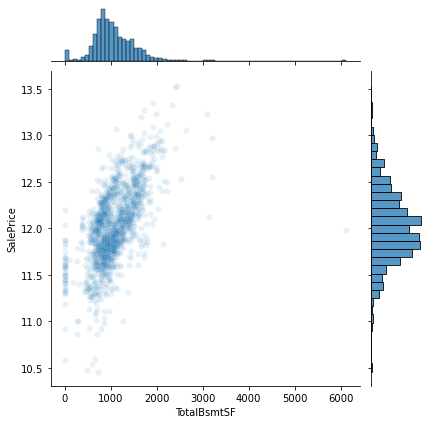

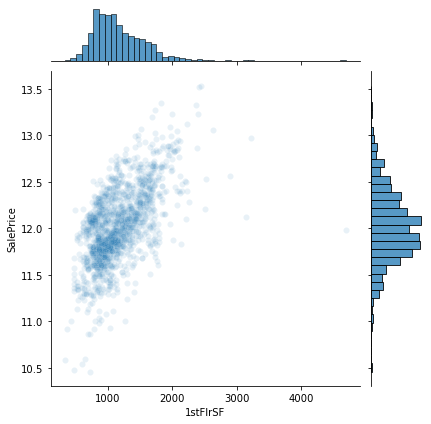

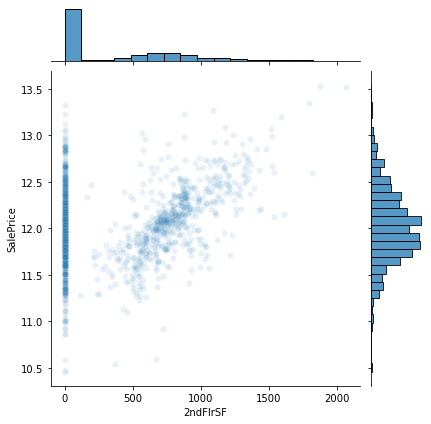

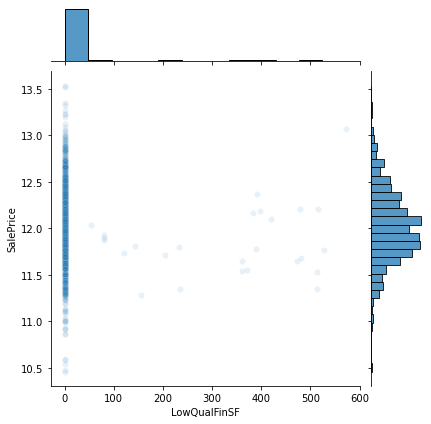

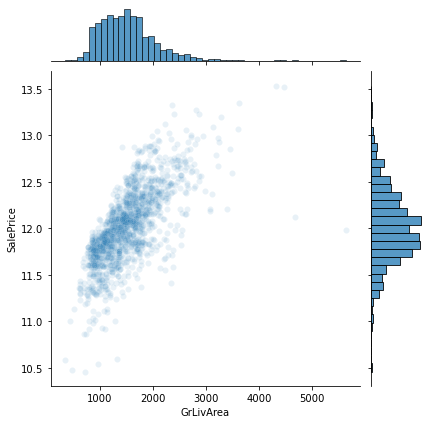

In [22]:
cat_vars = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','FireplaceQu',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces']
num_vars = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea']

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,40))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Exterior Information
- PoolQC: quality: ordinal
- Fence: quality: (good privacy, good wood, minimum)

- WoodDeckSF: deck square feet
- OpenPorchSF: Open porch  square feet
- EnclosedPorch: square feet
- 3SsnPorch: Three season square feet
- ScreenPorch: Screen  square feet
- PoolArea: Pool square feet

##### Feature Engineering
- Might be able to combine all porches into two features: PorchType, PorchSF. Do houses have more than 1 porch?
- Pool QC seems to add little between Fa/Gd

Columns with missing values
PoolQC    1453
Fence     1179
dtype: int64


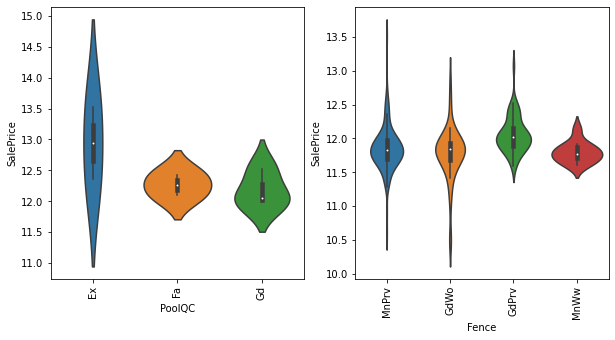

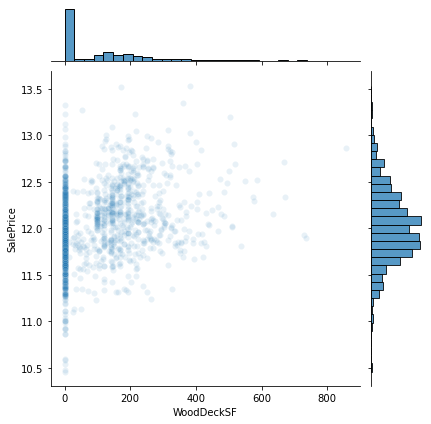

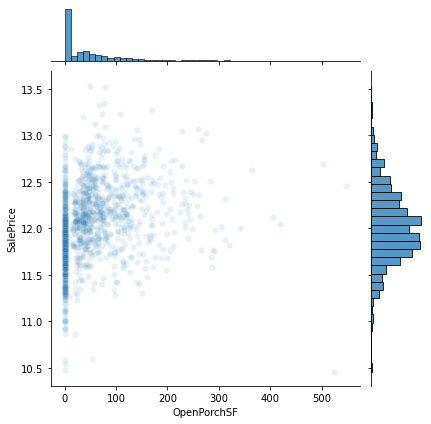

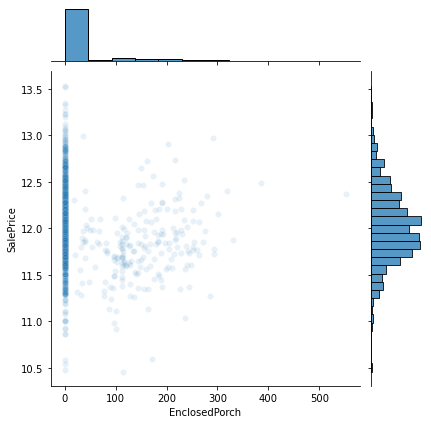

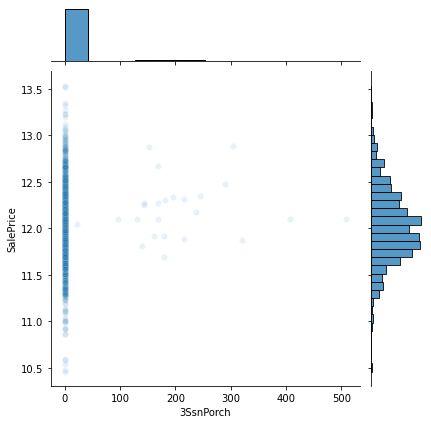

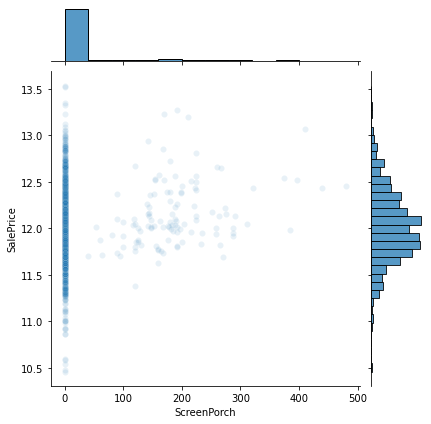

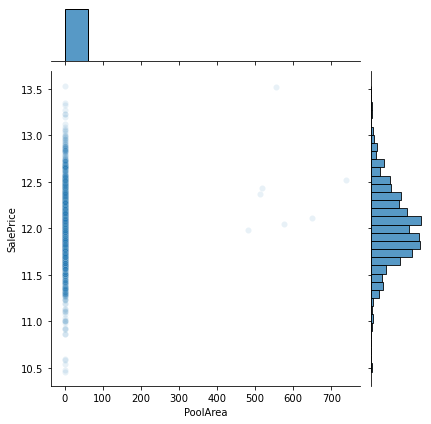

In [16]:
cat_vars = ["PoolQC","Fence"]
num_vars = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Garage
- GarageType: location (attached, basement, builtin)
- GarageFinish: finish (finished, rough, unfinished, no garage)
- GarageQual: quality: ordinal
- PavedDrive: yes, parital, dirt

- GarageYrBlt: year built
- GarageCars: car capacity
- GarageArea: size in square feet

##### Feature Engineering
- BuiltIn and Attached garages do better as well as finished.
- Supprisingly, excellent quality garages have a very wide distribution
- Garage Area and number of cars are correlated with price (and likely eachother)
- Missingness: Type, finish, year built and quaility are missing because there likely isnt a garage. 

Columns with missing values
GarageType      81
GarageFinish    81
GarageQual      81
GarageYrBlt     81
dtype: int64


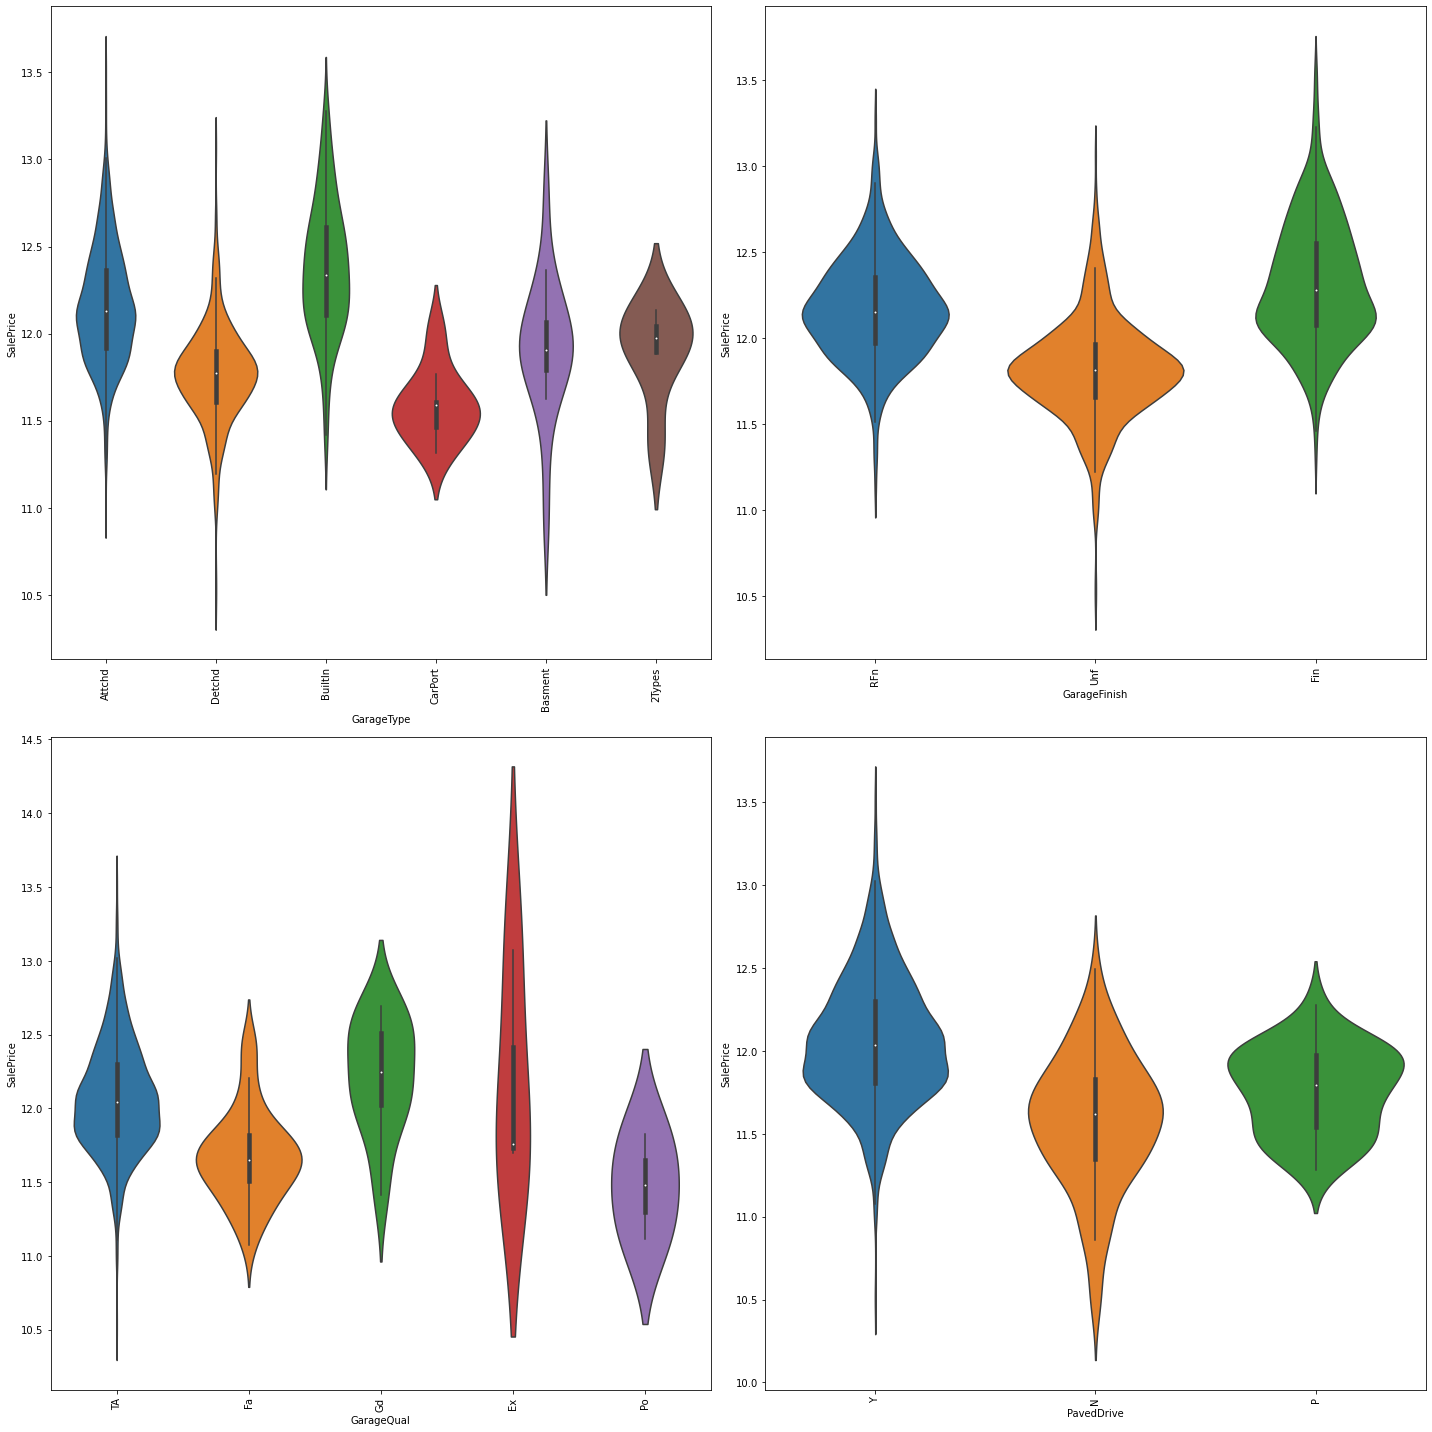

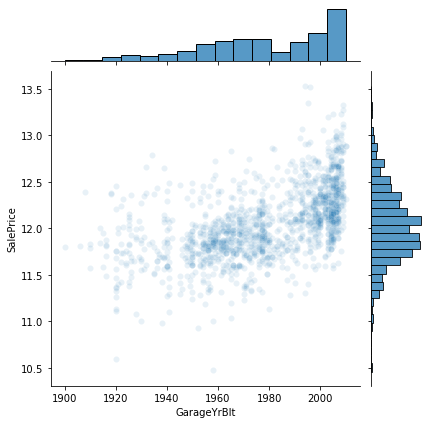

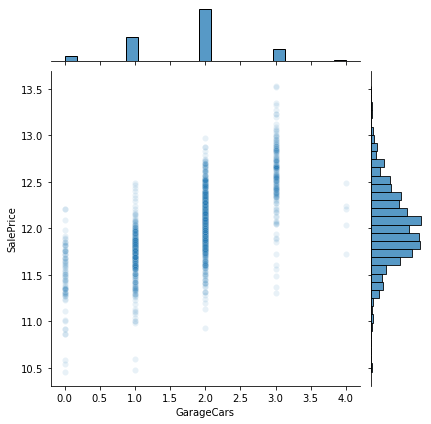

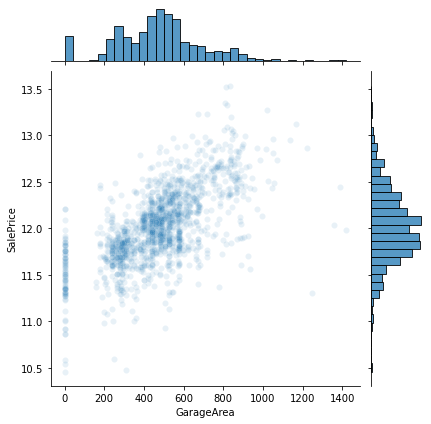

In [23]:
cat_vars = ["GarageType","GarageFinish","GarageQual","PavedDrive"]
num_vars = ["GarageYrBlt","GarageCars","GarageArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Additional Information
- Functional: functionality Typical, minor, major, severe, salvage
- MiscFeature: other features (elevator, shed, tennis court)
- SaleType: type of sale
- SaleCondition: issues with sale (abnormal, adjoining land, family sale, 

- MiscVal: $ value of misc features
- MoSold: month sold
- YrSold: year sold

- ID: Unique identifier
- SalePrice: sale price of houses target variable

##### Additional Information Feature Engineering
- Year and Month sold could obviously be combined. Would be interesting to see if we can see prices rising across these 10 years. Interestingly it also captures the 2009 housing crash. 
- 'Functional' and 'MiscFeature' seem to contain groups with 1 value (Sev and TenC)
- should MiscFeature just be added without coefficents?
- 

Columns with missing values
MiscFeature    1406
dtype: int64


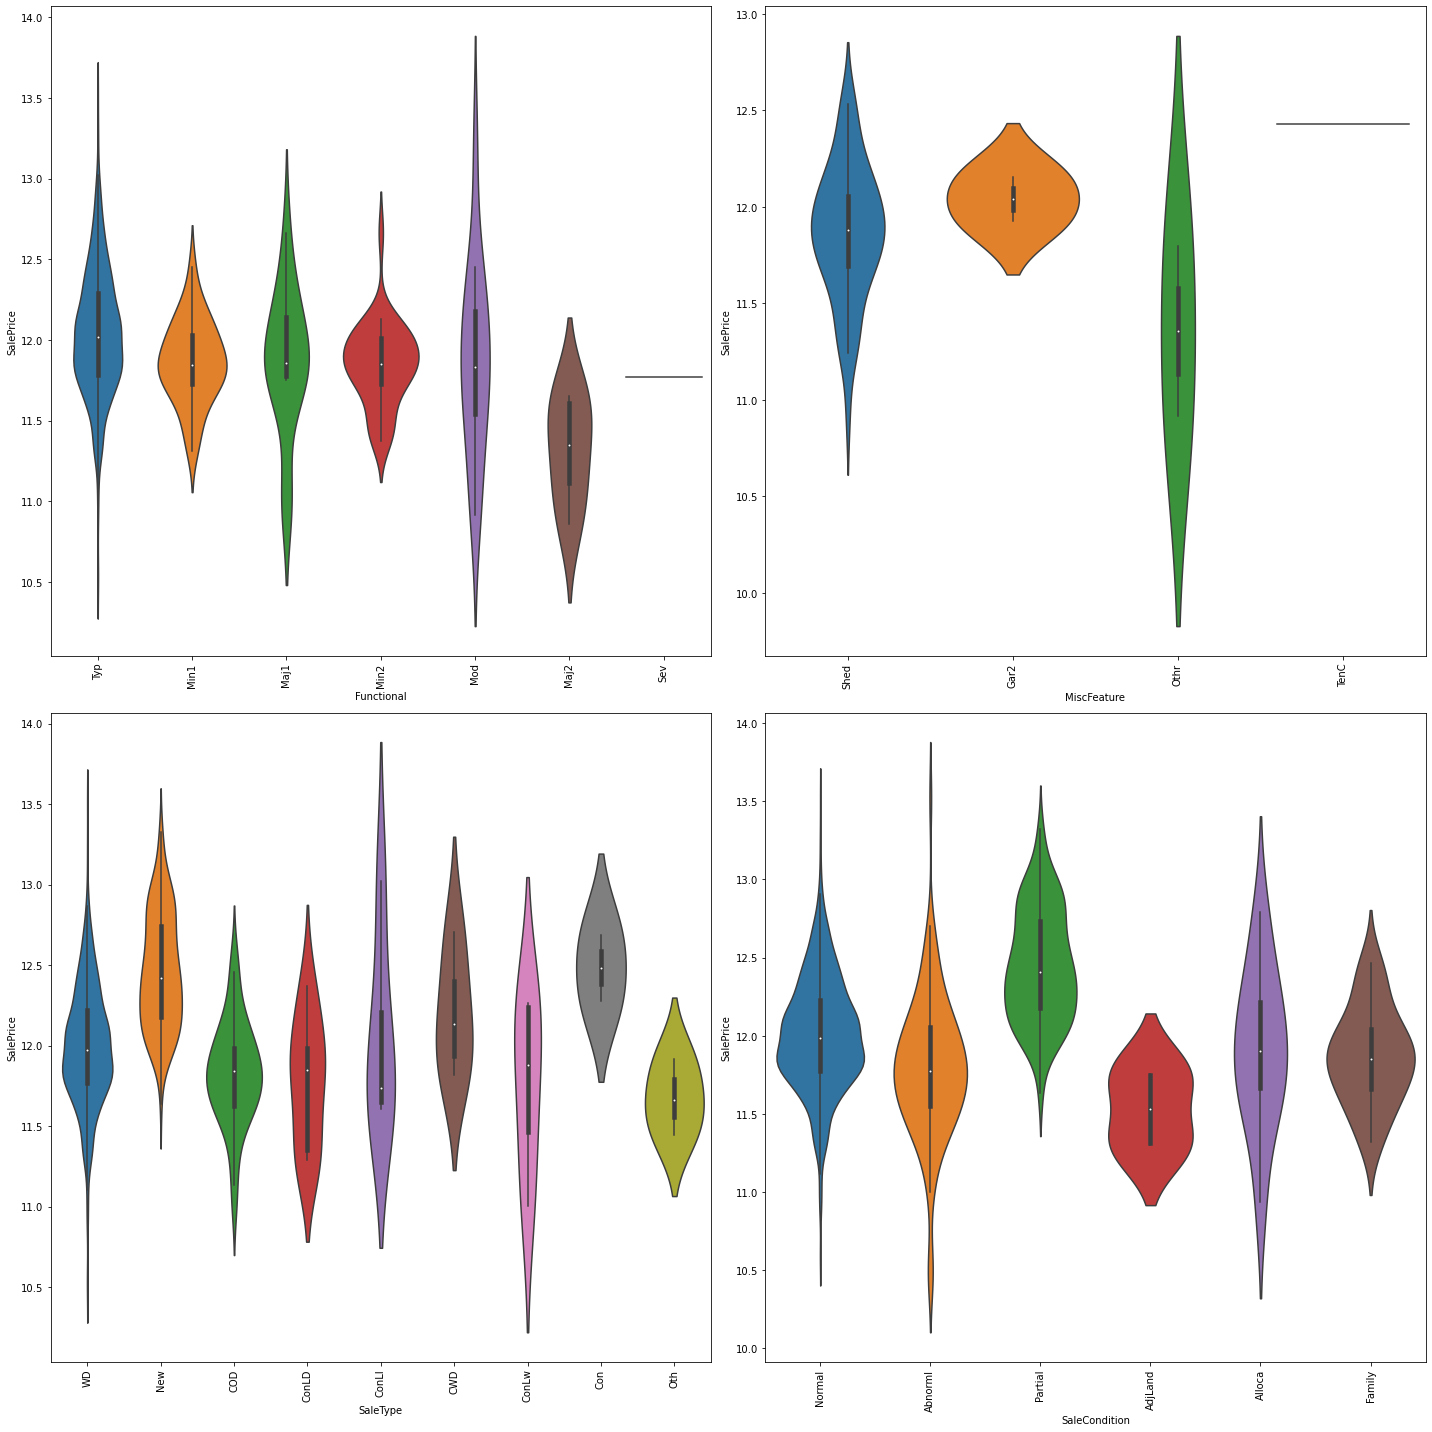

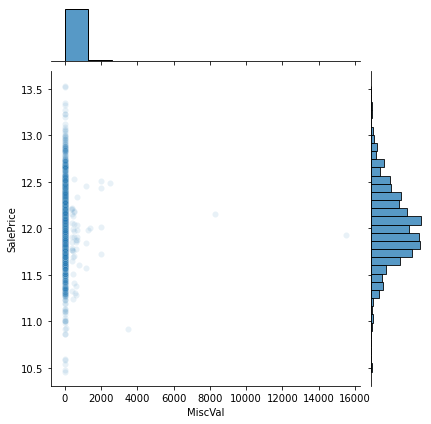

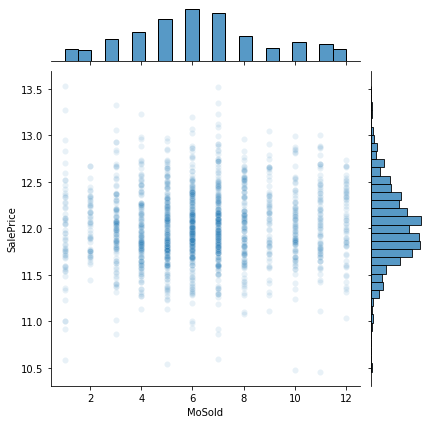

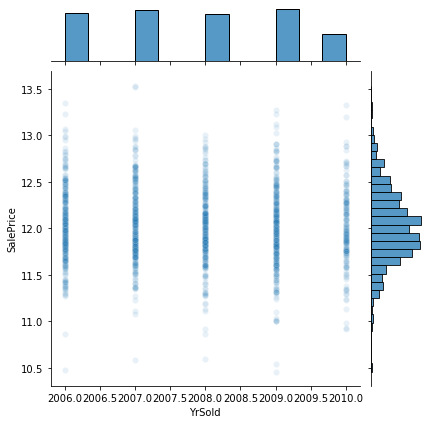

In [25]:
cat_vars = ["Functional","MiscFeature","SaleType","SaleCondition"]
num_vars = ["MiscVal","MoSold","YrSold"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

## Feature Exploration Graphics

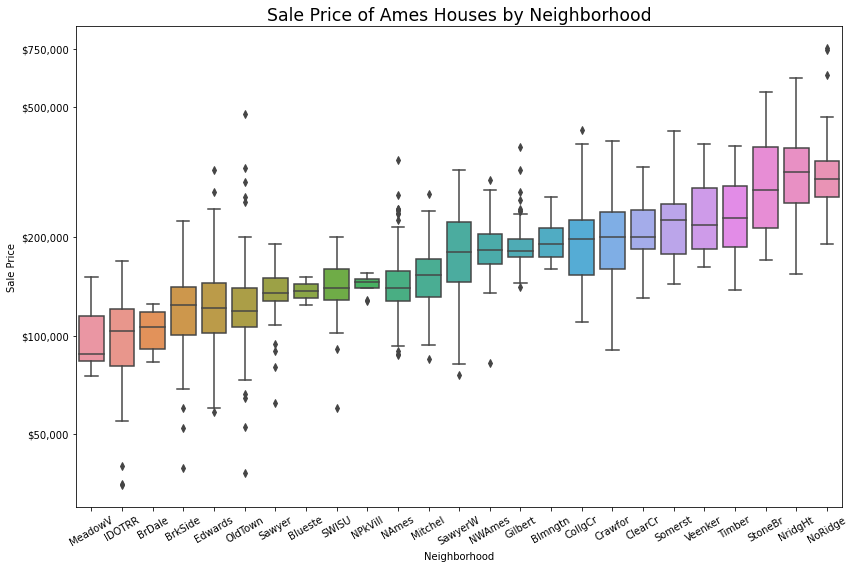

In [212]:
#Neighborhoods
train = custom_import(train_only=1)
train['SalePrice'] = target
order = train.groupby('Neighborhood').agg({'SalePrice':'mean'}).sort_values('SalePrice').index

plt.figure(figsize=(12,8))
plot = sns.boxplot(x = 'Neighborhood', y = np.log(target), data = train,order=order)

plot.set_ylabel("Sale Price")
plot.set_title("Sale Price of Ames Houses by Neighborhood",fontsize='xx-large')

plot.set_xticklabels(labels = order, rotation=30)

yticks = [50000,100000, 200000, 500000, 750000]
ytick_labels = ["${:,}".format(x) for x in yticks]

plot.set_yticks(np.log(yticks))
plot.set_yticklabels(ytick_labels)

plt.tight_layout()
plt.savefig('./graphics/price_vs_neighborhood.png')

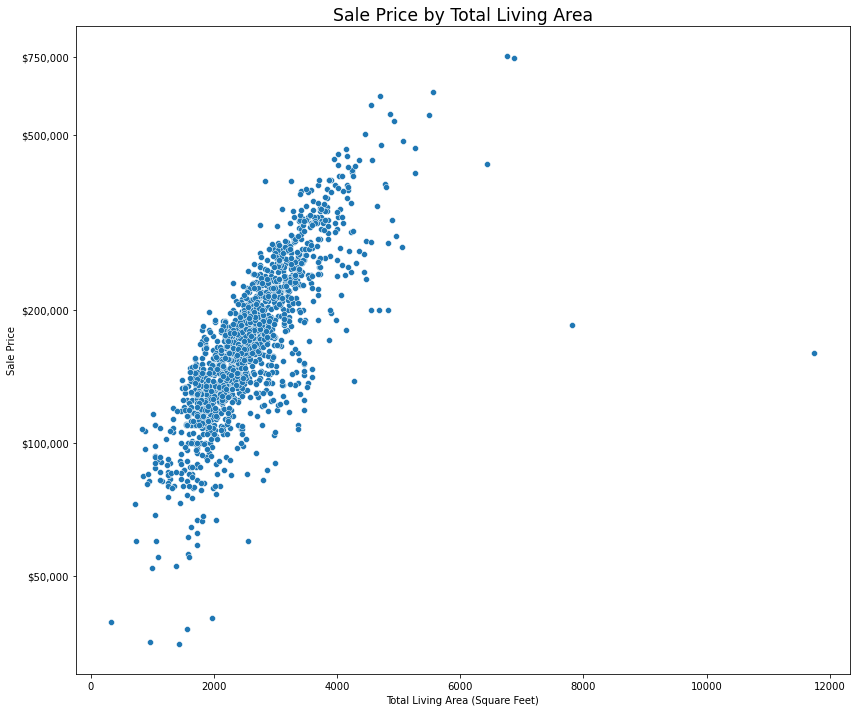

In [211]:
train = custom_import(train_only=1)
plt.figure(figsize=(12,10))
plot = sns.scatterplot(x = train['GrLivArea']+train['TotalBsmtSF'], y = np.log(target))

plot.set_title("Sale Price by Total Living Area", fontsize = 'xx-large')
plot.set_ylabel("Sale Price")
plot.set_xlabel("Total Living Area (Square Feet)")

yticks = [50000,100000, 200000, 500000, 750000]
ytick_labels = ["${:,}".format(x) for x in yticks]

plot.set_yticks(np.log(yticks))
plot.set_yticklabels(ytick_labels)

plt.tight_layout()
plt.savefig('./graphics/price_vs_livearea.png')

Some features are unimportant as judged by mutual information below.

<Figure size 432x288 with 0 Axes>

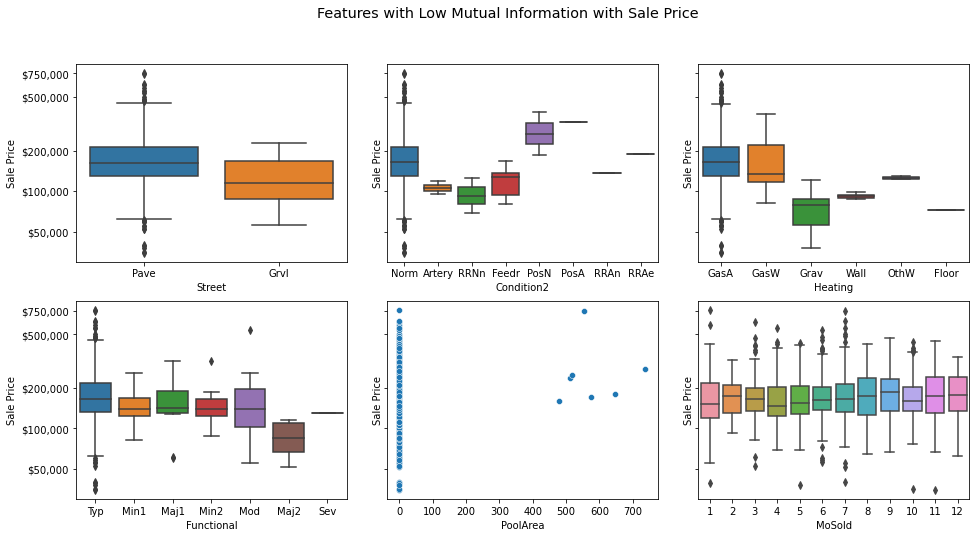

In [210]:
# inimportant variables
low_mutualinfo = ['Street','Condition2','Heating','Functional','PoolArea',"MoSold"]
low_mi_labels  = ["Street Condition", "Proximity to Condition","Heating Type","Pool Area (SF)","Month Sold"]

plt.tight_layout()
fig, ax = plt.subplots(2,3, figsize = (16,8), sharey=True)
fig.subplots_adjust(wspace = .15)

yticks = [50000,100000, 200000, 500000, 750000]
ytick_labels = ["${:,}".format(x) for x in yticks]

for var,loc in zip(low_mutualinfo, ax.flatten()):
    if var != "PoolArea":
        sns.boxplot(x= train[var], y = np.log(target),ax = loc)
    else:
        sns.scatterplot(x=train[var], y=np.log(target),ax=loc)
        loc.set_ylabel("Sale Price")
        loc.yaxis.get_label().set_visible(True) #why...
        
    loc.set_yticks(ticks=np.log(yticks))
    loc.set_yticklabels(ytick_labels)
    loc.set_ylabel("Sale Price")


fig.suptitle('Features with Low Mutual Information with Sale Price',fontsize = 'x-large')
plt.savefig('./graphics/low_mutual_info.png')


# Outlier Removal & Function <a id='outlier'></a>

[Back to Top](#top)

From the feature visualization above, it is fairly easy to spot possible outliers in numeric and categorical variables. Utlities only has categories with only 1 value. Other numeric features like BsmtFinSF1 & TotalBsmtSF have values with high z-scores.

Some possible outliers like a large Enclosed Porch and a category with only 1 condition in Condition2 were left alone due to being 'cleaned-up' in the feature engineering. Enclosed Porch is pivoted into two columns with the rest of the porch variables. Condition2 values are grouped with Condition1 and dummified.


In [104]:
def outlier_removal(data_outlier):
    init_size    = data_outlier.shape[0]
    data_outlier = data_outlier[data_outlier.Utilities == "AllPub"]
    data_outlier = data_outlier[data_outlier.GrLivArea < 4000]
    data_outlier = data_outlier[data_outlier.LotArea < 100000]
    final_size   = data_outlier.shape[0]
    print("{} Columns Removed".format(init_size-final_size))
    data_outlier = data_outlier.reset_index().drop('index',axis=1)
    return data_outlier

In [685]:
print(train['Utilities'].value_counts())

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


There seem to be two houses which have abnormal squarefootage for the price. While this might not be detected with univariate analysis, adding the log-SalePrice makes them pop out. Specifically in BsmtFinSF1, 1stFlrSF, and GrLivArea.

Additionally, the creator of the dataset suggests removal of all points with a GrLivArea greater than 4000 SF. This suggestion was followed, removing 4 points. 

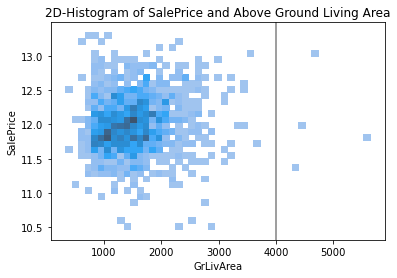

In [686]:
from scipy import stats

sns.histplot(x= train.GrLivArea, y = np.log(target))
plt.title("2D-Histogram of SalePrice and Above Ground Living Area")
plt.axvline(4000,alpha=0.5, color='k')

Text(0.5, 1.0, 'Z-Scores of GrLivArea')

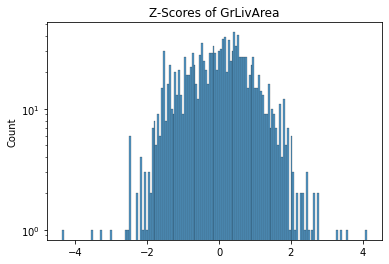

In [688]:
sns.histplot(x=(stats.zscore(np.log(train['GrLivArea'])).ravel()),bins = 160)
plt.yscale('log')
plt.title("Z-Scores of GrLivArea")

We can also see that there are several plots with large lot areas, and even with normalization (log) they still have a z-score greater than 4. These are removed.

Interestingly they are in neighborhoods at the edge of the city and are zoned for Low density residential zoning.

Text(0.5, 0.98, 'JointPlot of Sale Price and Lot Area')

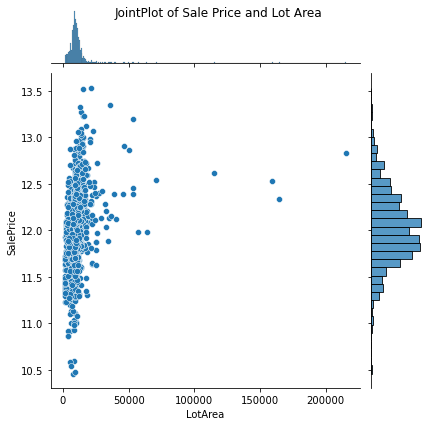

In [300]:
sns.jointplot(x=(train['LotArea']),y=np.log(target))
plt.suptitle("JointPlot of Sale Price and Lot Area")

Text(0.5, 1.0, 'Z-Scores of LotArea')

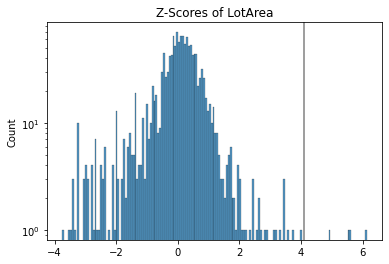

In [692]:
sns.histplot(x=(stats.zscore(np.log(train['LotArea'])).ravel()),bins = 160)
plt.yscale('log')
plt.axvline(4.1, alpha = 0.5, color = 'k')
plt.title("Z-Scores of LotArea")

#### Outlier Graphics

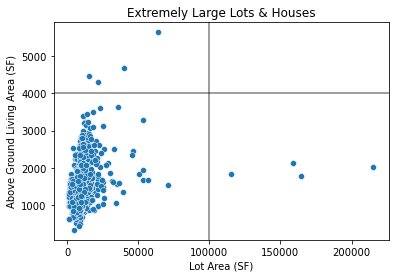

In [231]:
plot = sns.scatterplot(x=train.LotArea, y=train.GrLivArea)

plot.axhline(y=4000,color = 'k', alpha = 0.5)
plot.axvline(x= 100000,color = 'k', alpha = 0.5)

plot.set_ylabel("Above Ground Living Area (SF)")
plot.set_xlabel("Lot Area (SF)")
plot.set_title("Extremely Large Lots & Houses")
plt.savefig("./graphics/outliers.png")

# Multi-Collinearity <a id='multicolinearity'></a>

[Back to Top](#top)

Multi-collinearity can severly distort coefficients of the resulting model. Some regularized models can mitigate this effect but the models will preform better if multi-collinearity can be avoided. One method of juding multi-collinearity for numeric variables is Varience Inflation Factor or VIF. VIF works by 'predicting' each feature using a combination of other features (similar to mutual information as we will see later). Variables which are completly independent of other variables have a low VIF (approaching 0). Variables which can be perfectly predicted by other features have an infinite value. 

Generally VIFs greater than 2, 5, or 10 are considered worthy of removal or extreme caution (depending on the source). Below we can see that 8 variables have infinite VIFs (made visible on the graph for simplicity). There are 13 more variables which have a VIF greater than 10. Most of these can easily be explained, such as Total Basement SF being the sum of BsmtUnfSF, BsmtFinSF1, and BsmtFinSF2. Some are more complicated, YrSold, YearRemodAdd and YearBuilt all have similar VIFs, indicating collinearity. 

A similar trend is seen with the correlation plot below. 

C:\Users\James\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


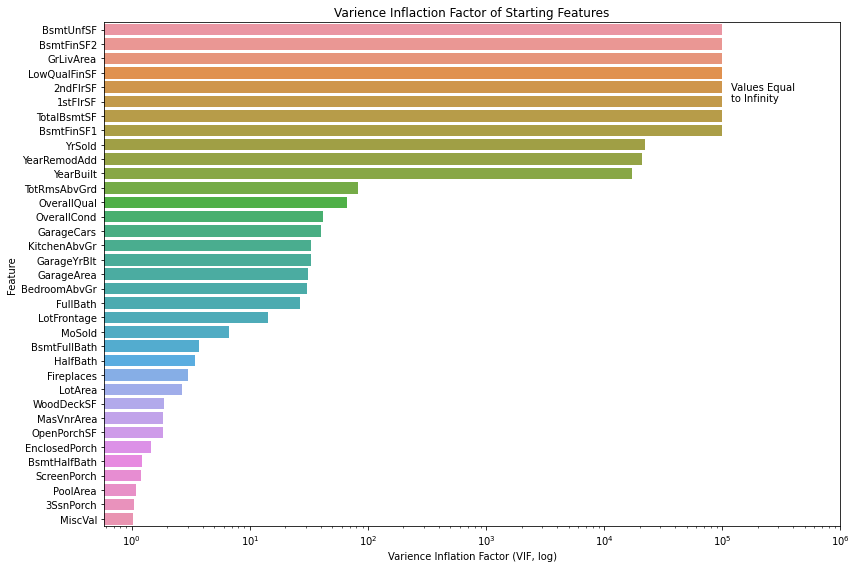

In [259]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

train = custom_import(train_only=True)

data = feature_cleaning(train)
data = data.select_dtypes(include='number').drop(['Id'],axis=1)

vif = pd.DataFrame()

vif['Feature'] = data.columns
vif['VIF']     = [variance_inflation_factor(data.values, x) for x in range(len(data.columns)) ]


plt.figure(figsize=(12,8))

data = vif.sort_values("VIF",ascending=False).replace({np.inf:1e+5})
plot = sns.barplot(y='Feature',x="VIF",data=data)
plt.xscale('log')
plt.xlim(right = 1e6)
plt.xlabel('Varience Inflation Factor (VIF, log)')
plt.title("Varience Inflaction Factor of Starting Features ()")

plot.text(x= 1.2e5,y= 5, s="Values Equal\nto Infinity")
plt.tight_layout()
plt.savefig('./graphics/vifplot.png')

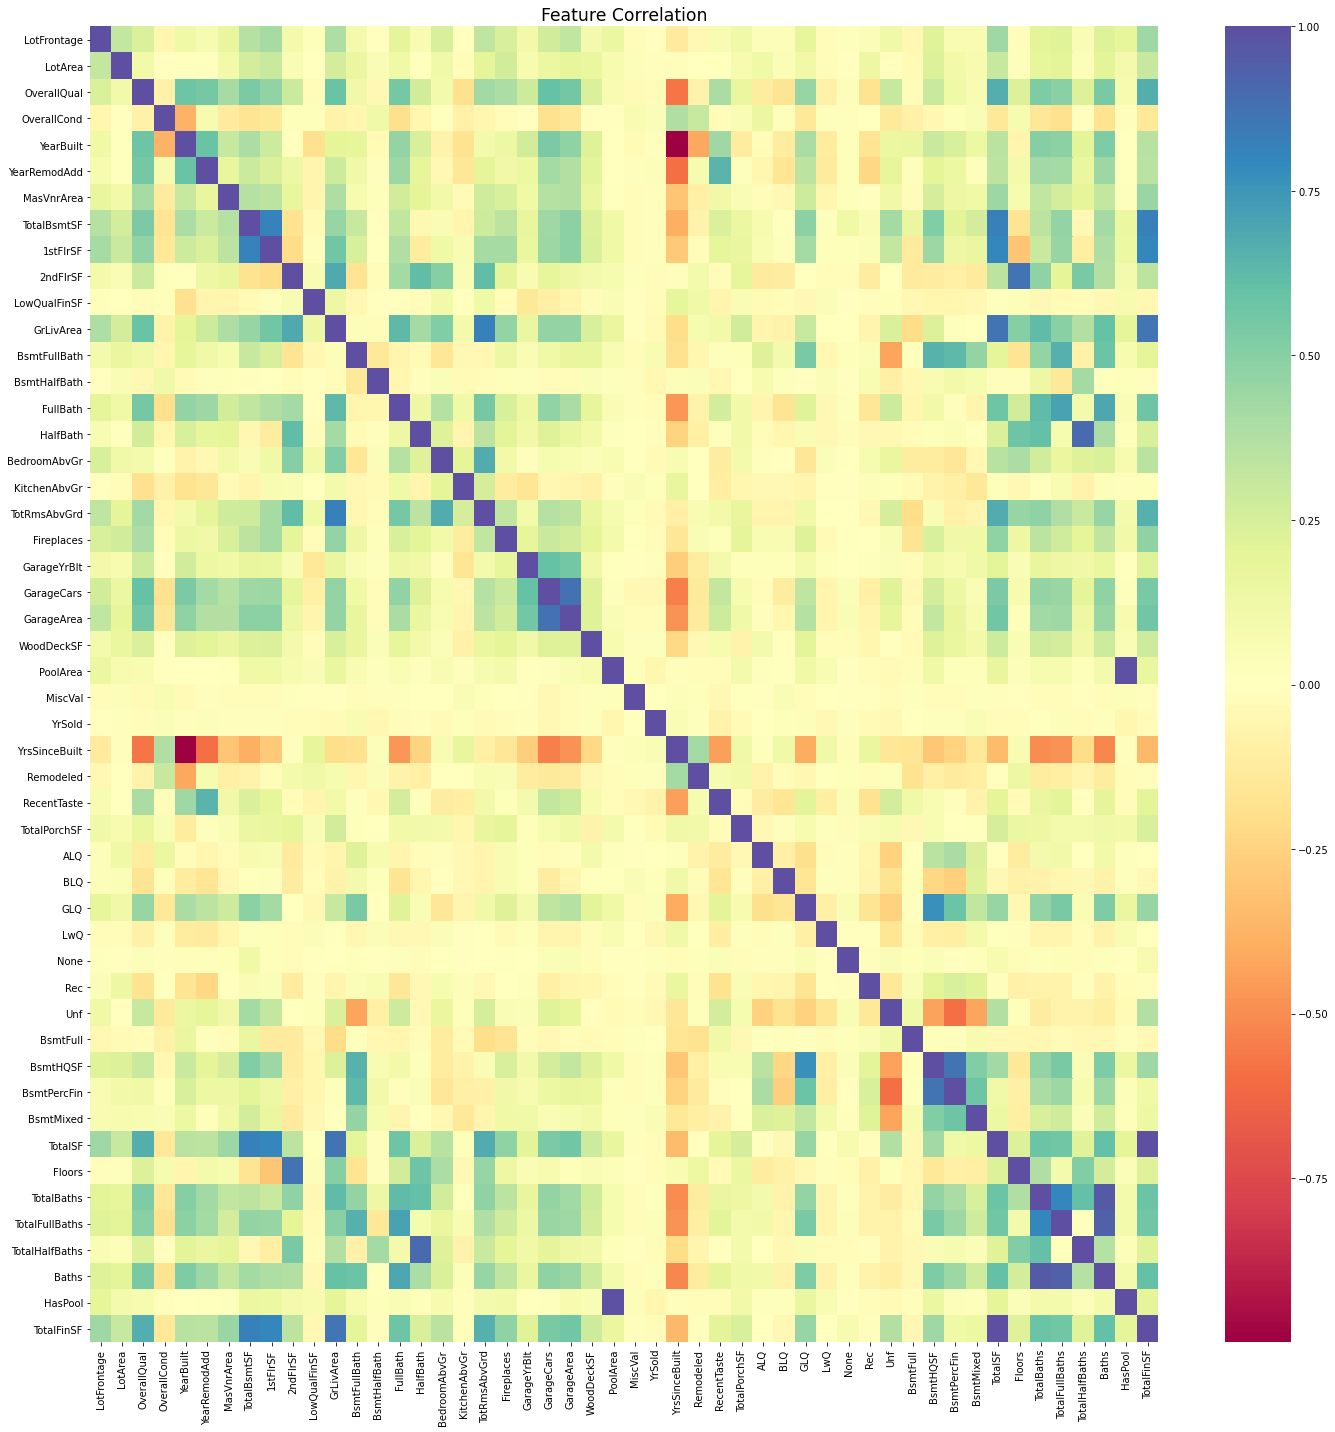

In [277]:
train = custom_import(train_only=True)
plt.figure(figsize=(20,20))
data = feature_engineering(feature_cleaning(train), dummify=False)
feature_cor = data.drop(['Id'],axis=1).corr()
plot = sns.heatmap(feature_cor, center = 0, cmap='Spectral')
plot.set_title("Feature Correlation", fontsize = 'xx-large')
plt.tight_layout()
plt.savefig("./graphics/corr_plot.png")

# Missing Values & Data Cleaning Function  <a id='cleaning'></a>

[Back to Top](#top)

Since this is a real world dataset, there are some missing values, both intentionally missing and missing at random.

Most of the features below list NA due to the lack of a feature, such as pools, fences, alleys and basements. These are not actually missing, NA is a value in the data key.

Leaving only LotFrontage, MasVnrType and Electrical as the missing values. MasVnrType and Electrical were imputed with the mode, while LotFrontage was imputed with the neighborhood & LotConfig mean, or the neighborhood if there werent enough lots to compare against. 

Lot Config was chosen due to the planned nature of midwestern communities, Lot sizes are standardized by development (neighborhood) so they only differ depending on if its a cul du sac, inner, or corner lot. 


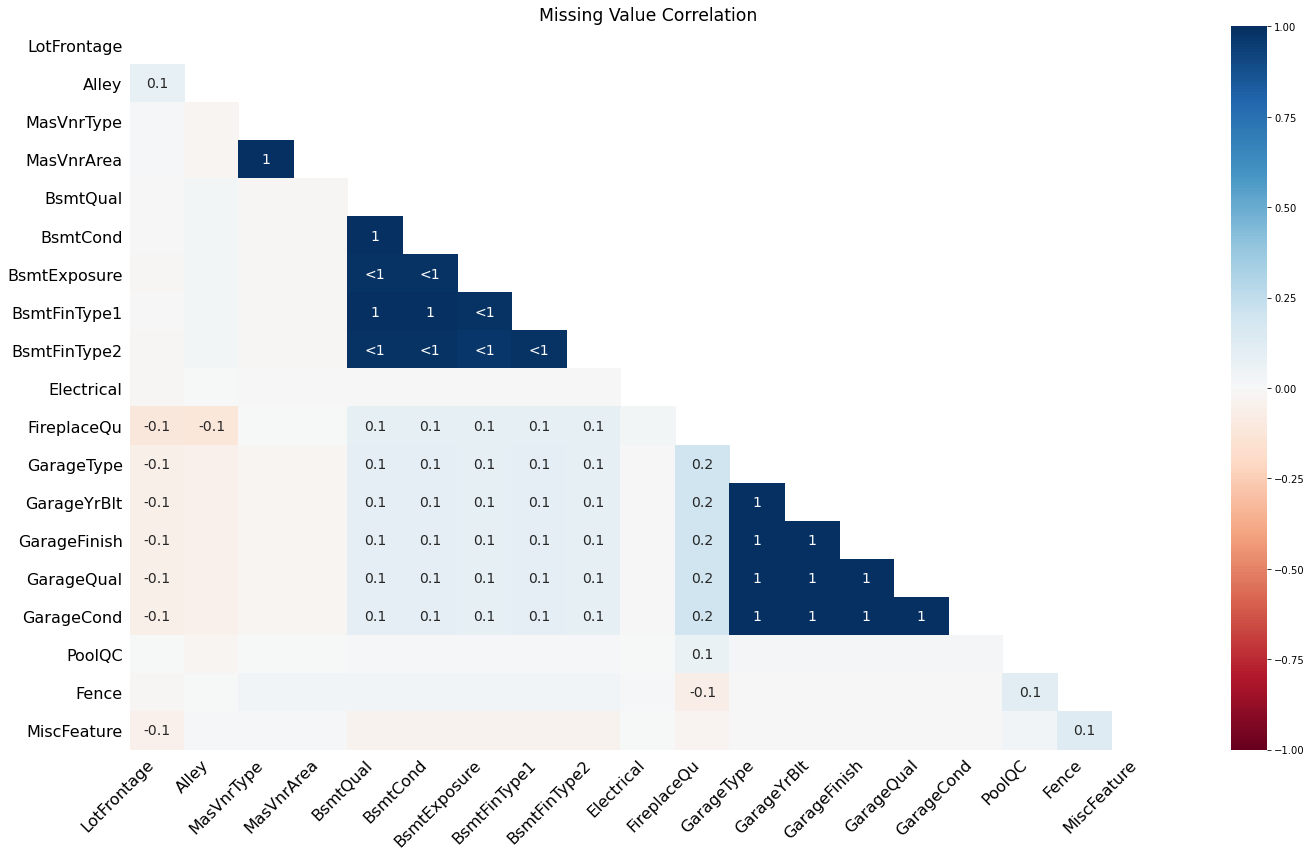

In [59]:
import missingno as msno

plot = msno.heatmap(train)
plt.title("Missing Value Correlation", fontsize = 'xx-large')
plt.tight_layout()
plt.savefig('./graphics/null_heatmap.png')

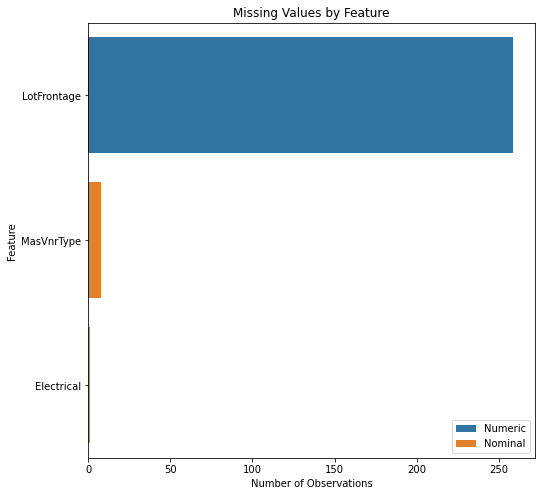

In [60]:
na_included = ["Alley",'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',"BsmtFinType2",'FireplaceQu',
               "GarageType",'GarageFinish','GarageQual','GarageCond','PoolQC',"Fence",'MiscFeature']

zero_normal = ['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath','ScreenPorch', 
               'BsmtFinSF2', 'EnclosedPorch', 'HalfBath', 'MasVnrArea','BsmtFullBath', '2ndFlrSF', 
               'WoodDeckSF', 'Fireplaces', 'OpenPorchSF','BsmtFinSF1', 'BsmtUnfSF', 'GarageYrBlt', 
               'GarageCars','GarageArea', 'TotalBsmtSF', 'FullBath', 'BedroomAbvGr','KitchenAbvGr']

nulls   = ((train == 0) | (train.isnull())).sum(axis=0)
labels  = train.dtypes.replace({"object":"Nominal","int64":"Numeric","float64":"Numeric"})

data = pd.concat([nulls,labels], axis = 1)
data.columns = ['nulls','labels']

data = data[data.nulls !=0].sort_values('nulls',ascending=False).drop(na_included).drop(zero_normal)
#colors = [1 if l == 'Nominal' else 0 for l in data.labels]


plt.figure(figsize=(8,8))
plot  = sns.barplot(x = data.nulls, 
                    y = data.index, 
                    orient='h', 
                    hue = data.labels, 
                    palette=sns.color_palette(),
                    dodge = False)

plot.set_ylabel("Feature")
plot.set_xlabel("Number of Observations")
plot.set_title("Missing Values by Feature")
plot.legend(loc = "lower right")


This function cleans the data, replacing missing values with numeric or character values in a context dependent manner. LotFrontage is imputed as the mean of the neighborhood and lot configuration (corner, cul de sac, regular). Some neighborhoods lack enough houses so the value is imputed by the neighborhood alone. This choice was made due to my knowledge of how lots are broken up by the city (standard sizes but negihborhoods are developed independently). 

Some are simple replacements, such as Alley's, Garage's, Basements, and Fireplaces: where NA -> "None".

Since the test set might have different values, a final pass of mode imputation is used. 


In [105]:
def feature_cleaning(data_to_clean):
    ''' Recodes several features, replaces Null values
    as nessesary for a select number of columns.
    Null to "None" and 0 are imputed for most columns. 
    
    Value:
    Returns a dataframe with modified columns. 
    '''
    
    # MSSubClass and ID uses numbers which are read-in as numeric but they are categorical.
    data_to_clean['MSSubClass'] = data_to_clean['MSSubClass'].astype(str)
    

    # imputing with most common
    data_to_clean.Electrical = data_to_clean.Electrical.replace(np.nan, "SBrkr")
    
    # Lot Frontage interpolation by Neighborhood and Lot Config (Cul de sac, inside, corner) mean. 5 values were missed so are filled with neighborhood mean.
    data_to_clean["LotFrontage"] = data_to_clean.groupby(["Neighborhood", "LotConfig"], sort = False)["LotFrontage"].apply(lambda x: x.fillna(x.mean()))
    data_to_clean["LotFrontage"] = data_to_clean.groupby(["Neighborhood"], sort= False)["LotFrontage"].apply(lambda x: x.fillna(x.mean()))
    
    # replacing np.nan to None for missing features (these do not exist in house)
    nan_to_none = ["Alley","MasVnrType","GarageType","GarageFinish","MiscFeature",
                   "PoolQC", "Fence","BsmtQual", "BsmtCond","BsmtExposure","BsmtFinType1",
                   "BsmtFinType2","FireplaceQu", "GarageQual", "GarageCond"]

    data_to_clean[nan_to_none] = data_to_clean[nan_to_none].replace(np.nan, "None")

    # Replacing np.nan in numeric columns with 0
    num_cols = data_to_clean.select_dtypes('number').columns.drop("Id", errors='ignore')
    data_to_clean[num_cols] = data_to_clean[num_cols].replace(np.nan, 0)
    
    
    # Exterior2nd includes 3 misspelled categories totaling almost 100 observations
    data_to_clean = data_to_clean.replace({'Exterior2nd':{"Brk Cmn":"BrkComm", "CmentBd":"CemntBd","Wd Shng": "WdShing"}}) 
    
    
    # Unfortunetly this is all manual but I wanted to keep it togeather.
    # Coercing all columns to stadard rating format Ex,Gd,TA,Fa,Po,None
    non_standard_ordinals = ["BsmtExposure","GarageFinish","Fence"]
    replace_ratings = {"Fence" : {"GdPrv":"Gd","MnPrv":"TA","GdWo":"Fa","MnWw":"Po"},
                       "GarageFinish" : {"Fin":"TA","RFn":"Fa","Unf":"Po"},
                       "BsmtExposure" : {"Av":"TA","Mn":"Fa","No":"Po"}}
    data_to_clean[non_standard_ordinals] = data_to_clean[non_standard_ordinals].replace(replace_ratings)
    
    if data_to_clean.isnull().any().any():
        print("Filling Missing at Random Data")
        for col in data_to_clean.columns[data_to_clean.isnull().any()]:
            data_to_clean[col] = data_to_clean[col].replace(np.nan,data_to_clean[col].mode()[0])            
            
    
    
    return data_to_clean

## Feature Engineering Function <a id='feature_eng'></a>

[Back to Top](#top)

This function holds all the feature engineering I wanted to built into the model. Generally this fell into 3 groups.

**1. Re-phrase:**
- MoSold numeric -> Categorical because 12 (Dec) and 1 (Jan) are more similar than 1 & 4 season wise.
- Date Columns: I choose to
**2. Pivot: Data in multiple columns, rearragned**
- All Porch variables were pivoted to a Porch_Type and TotalPorchSF instead of each type being a column. 
- Each Basement Finish received it's own column tracking the square footage. So instead of modeling BsmtType as a dummified variable, it gets modeled on the SF of that area. Unfinished Basement SF is seperate and was rolled into this column set.
- Each Road Condition was given its own column effectively dummifying the variable. But this handles it better than the built in method since it's across two columns.
**3. Custom:**
- Some dummy varaibles such as "Remodeled", and "HasPool"
- Total X: Square Feet, Baths, Bedrooms, Floors

In [106]:
def feature_engineering(data_to_eng, dummify = True):
    '''Feature engineering, dummify is set to True as default,
    this will dummfiy the "Condition1" and "Condition2" columns,
    combining the dummified features (since they are redundant).
    
    Value:
    Returns dataframe, with added columns and recoded columns removed.
    '''
    
    #Date features
    data_to_eng["YrsSinceBuilt"]    = data_to_eng.YrSold - data_to_eng.YearBuilt
    data_to_eng["Remodeled"]        = data_to_eng.YearBuilt != data_to_eng.YearRemodAdd
    data_to_eng["RecentTaste"]      = (data_to_eng.YrSold - data_to_eng.YearRemodAdd) < 6

    min_garage_yr                   = min(data_to_eng.GarageYrBlt)
    data_to_eng["GarageYrBlt"]      = [0 if pd.isnull(x) else x - min_garage_yr for x in data_to_eng.GarageYrBlt]

    months                          = ["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    data_to_eng["MoSold"]           = [months[m] for m in data_to_eng.MoSold]
    
    
    # Combining 4 porch variables into 2, PorchType and TotalPorchSF. 
    # Excluding WoodDeck because it requires a different permit type.
    porch_vars = ['OpenPorchSF',"EnclosedPorch","3SsnPorch","ScreenPorch"]
    porch_pivot = data_to_eng[porch_vars].astype(bool).replace({'OpenPorchSF':{True:'OpenPorchSF',False:np.nan},
                                            'EnclosedPorch':{True:'EnclosedProch',False:np.nan},
                                            '3SsnPorch':{True:'3SsnPorch',False:np.nan},
                                            'ScreenPorch':{True:'ScreenPorch',False:np.nan}}).apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

    data_to_eng["PorchType"]    = ["NoPorch" if x.split(',')==[""] else "Multiple" if len(x.split(','))>1 else x for x in porch_pivot]
    data_to_eng["TotalPorchSF"] = data_to_eng[porch_vars].sum(axis = 1)
    data_to_eng = data_to_eng.drop(porch_vars, axis=1)
  
    # pivot features & SF into their own dataframes.
    bsmt1 = data_to_eng.pivot(index = 'Id',columns="BsmtFinType1",values="BsmtFinSF1").replace(np.nan,0)
    bsmt2 = data_to_eng.pivot(index = 'Id',columns="BsmtFinType2",values="BsmtFinSF2").replace(np.nan,0)
    
    # combine bsmt features and groupby column names, and sum acorss columns (since bsmt1 and 2 have the same features.)
    Bsmt_Feat_SF        = pd.concat([bsmt1,bsmt2],axis=1)
    Bsmt_Feat_SF        = Bsmt_Feat_SF.groupby(Bsmt_Feat_SF.columns, axis=1).sum().reset_index()
    Bsmt_Feat_SF['Unf'] = data_to_eng['BsmtUnfSF']
    Bsmt_Feat_SF        = Bsmt_Feat_SF.drop("Id",errors='ignore',axis=1)

    data_to_eng         = pd.concat([data_to_eng, Bsmt_Feat_SF], axis=1)
    data_to_eng         = data_to_eng.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF'], errors = 'ignore', axis=1)
    
    
    # Some Misc Basement Features
    data_to_eng['BsmtFull']    = (data_to_eng['1stFlrSF'] <= data_to_eng.TotalBsmtSF).astype(int)
    data_to_eng['BsmtHQSF']    = Bsmt_Feat_SF[["ALQ","GLQ","Rec"]].sum(axis=1)
    data_to_eng['BsmtPercFin'] = (data_to_eng["BsmtHQSF"] / data_to_eng["TotalBsmtSF"]).replace(np.nan, 0)
    data_to_eng['BsmtMixed']   = (data_to_eng[["ALQ","BLQ","GLQ","LwQ","Rec","Unf"]].astype(bool).astype(int).sum(axis=1) > 1).astype(int)

    
    # Some Misc Housing Features.
    data_to_eng['TotalSF']        = data_to_eng[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].sum(axis=1)
    data_to_eng['Floors']         = data_to_eng[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].astype(bool).astype(int).sum(axis=1)
    data_to_eng['TotalBaths']     = data_to_eng[['BsmtFullBath',"BsmtHalfBath","FullBath","HalfBath"]].sum(axis=1)
    data_to_eng['TotalFullBaths'] = data_to_eng[['BsmtFullBath',"FullBath"]].sum(axis=1)
    data_to_eng['TotalHalfBaths'] = data_to_eng[["BsmtHalfBath","HalfBath"]].sum(axis=1)
    data_to_eng['Baths']          = data_to_eng['TotalFullBaths'] + 0.5 * data_to_eng['TotalHalfBaths']
    data_to_eng["HasPool"]        = (data_to_eng['PoolArea'] > 0 ).astype(int)
    data_to_eng["TotalFinSF"]     = data_to_eng['TotalSF'] - data_to_eng['LowQualFinSF']
    data_to_eng['YardSF']         = data_to_eng['LotArea'] - (data_to_eng['1stFlrSF'] + 
                                                              data_to_eng['PoolArea'] + 
                                                              data_to_eng['GarageArea'] + 
                                                              data_to_eng['TotalPorchSF'])
    
    if dummify:
        # Dummify "Condition1/2" and combine both columns via any().astype()
        road_conds = pd.get_dummies(data_to_eng[["Condition1","Condition2"]], prefix = "Condition", prefix_sep = "_",columns = ["Condition1","Condition2"], dtype=bool)
        road_conds = road_conds.groupby(road_conds.columns, axis = 1).any().astype(int)
        data_to_eng = pd.concat([data_to_eng,road_conds], axis = 1).drop(["Condition1","Condition2"],axis=1)
        
        # Dummify 'Exterior1st/2nd' and combine into dummy columns
        exterior  = pd.get_dummies(data_to_eng[["Exterior1st","Exterior2nd"]], prefix = "Exterior", prefix_sep = "_",columns = ["Exterior1st","Exterior2nd"], dtype=bool)
        exterior  = exterior.groupby(exterior.columns, axis = 1).any().astype(int)
        data_to_eng = pd.concat([data_to_eng,exterior], axis = 1).drop(["Exterior1st","Exterior2nd"],axis=1)
    
    return data_to_eng

# Label Encoding

Sklearn random forest does not have natural categorical data parsing methods. The LabelEncoder function is useful but documentation suggests it is only used on the target variable. Label Encoder does not handle multiple columns well or retain multiple dictionaries. 

The functions below act as a label encoder with ordinality based on the supplied target feature, retaining a dictionary of the transformation of each column and construction a dictonary-of-dictionaries which allows un-encoding. 

In [107]:
def better_LabelEncoder(to_encode, target):
    ''' Takes a filtered dataframe and a target variable to sort by.
    Returns a tuple consisting of an encoded dataframe and 
    dictionary of dictionaries containing the column names, and 
    key-value pairs for later inversion.
    
    Values: dataframe, dictionary
    '''
    label_values = dict()
    
    for column in to_encode.columns:
        #Pivot Each Column and Target, get median for each category, sort and reset the index
        joined = pd.DataFrame({"Categories": to_encode[column],"Target": target})\
                   .groupby("Categories") \
                   .agg({"Target":"median"}) \
                   .sort_values("Target") \
                   .reset_index()
        
        #Dictionary Construction
        local_dict =  dict(zip(joined['Categories'],joined.index))
        label_values[column] = local_dict
        
        to_encode[column] = to_encode[column].replace(local_dict)
        
    return (to_encode, label_values)
    
    
def better_LabelDecoder(to_decode, inverter):
    '''Takes dataframe and dictionary of dictionaries
    representing the column names and key-value pairs
    of the labelencoded dataframe.
    
    Value: A dataframe with the label replaced with original value.
    '''
    
    for column in to_decode.columns:
        try: 
            local_dict = inverter[column] 
            local_dict = {v:k for k,v in local_dict.items()}
        except:
            ValueError("Column Name not found in dictionary")
    
        to_decode[column] = to_decode[column].replace(local_dict)
        
    return to_decode

# Preprocessing <a id='preprocessing'></a>

[Back to Top](#top)

The following cells implement the data cleaning and feature engineering outlined above. In addition, the data is encoded using SKlearn preprocessors such as Ordinal, and OneHot encoding. Finally a powertransformer is applied to all columns to standardize and normalize values. 

A final round of cleaning removes the "ID" columns and transforms the target column

#### Outlier Removal

In [629]:
train, test, target = custom_import()

train_target = outlier_removal(pd.concat([train,target], axis=1))
target = train_target["SalePrice"] 
train  = train_target.drop(labels = ['SalePrice'], axis = 1)

9 Columns Removed


#### Linear Model Data Prep

In [630]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, PowerTransformer


# Missing Value Imputation
train_lm = feature_cleaning(train)
test_lm  = feature_cleaning(test)
print("Train: Missing Values: {}".format(train_lm.isna().sum().sum()))
print("Train: Missing Vlaues: {}".format(test_lm.isna().sum().sum()))


# Feature Engineering
train_lm = feature_engineering(train_lm)
test_lm = feature_engineering(test_lm)


# ORDINAL ENCODING
ordinal_cols   = ['ExterQual','ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure','HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence']
# Dictionary & ratings for each column
standard_rating_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"None":0}
standard_rating = pd.Series(standard_rating_dict).sort_values().index.tolist()
standard_rating = [standard_rating]*len(ordinal_cols)


# Create Ordinal Encoder
Ord_enc = OrdinalEncoder(categories=standard_rating, dtype=float)

# Fit based on the train data, transform both and swap columns. 
train_lm[ordinal_cols] = Ord_enc.fit_transform(train_lm[ordinal_cols])
test_lm[ordinal_cols]  = Ord_enc.transform(test_lm[ordinal_cols])


# ONE HOT ENCODING
# Define categorical columns, droping ordinals to be sure
nominal_cols   = train_lm.select_dtypes(include = 'object').columns.drop(ordinal_cols,errors = 'ignore').tolist()

OH_enc = OneHotEncoder(drop=None, handle_unknown = 'ignore',sparse=False)

# Fit and transform Train, concatenate 
OHE_train    = OH_enc.fit_transform(train_lm[nominal_cols])
OH_cols      = OH_enc.get_feature_names(nominal_cols).tolist()
train_lm     = pd.concat([train_lm, pd.DataFrame(OHE_train, columns = OH_cols)],axis=1)
train_lm     = train_lm.drop(nominal_cols,axis=1)

OHE_test    = OH_enc.transform(test_lm[nominal_cols])
test_lm     = pd.concat([test_lm, pd.DataFrame(OHE_test, columns = OH_cols)],axis=1)
test_lm     = test_lm.drop(nominal_cols,axis=1)

OH_cols = OH_cols + (train_lm.filter(regex=(r"^Condition.*|^Exterior.*"), axis=1).columns).tolist() +["BsmtMixed","HasPool","Remodeled","RecentTaste"]

# Define numeric columns, adding ordinals for normalization
numerical_cols = train_lm.select_dtypes(include = 'number').columns.drop(labels = ["Id"]+nominal_cols+OH_cols, errors='ignore').tolist()


# NUMERIC STANDARDIZATION
Norm_enc = PowerTransformer(method="yeo-johnson")


# Fit on Train and transform both
train_lm[numerical_cols] = Norm_enc.fit_transform(train_lm[numerical_cols])
test_lm[numerical_cols]  = Norm_enc.transform(test_lm[numerical_cols]) 



Filling Missing at Random Data
Train: Missing Values: 0
Train: Missing Vlaues: 0


C:\Users\James\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\James\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


#### Tree Model Data Prep

In [631]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, PowerTransformer

# Missing Value Imputation
train_tree = feature_cleaning(train)
test_tree = feature_cleaning(test)
print("Train: Missing Values: {}".format(train_tree.isna().sum().sum()))
print("Train: Missing Vlaues: {}".format(test_tree.isna().sum().sum()))


# Feature Engineering
train_tree = feature_engineering(train_tree, dummify = False)
test_tree  = feature_engineering(test_tree, dummify = False)

ordinal_cols   = ['ExterQual','ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure','HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence']

# ORDINAL ENCODING
# Not strictly needed, but some tree models do not natively handle strings
# Dictionary & ratings for each column
standard_rating_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"None":0}
standard_rating      = pd.Series(standard_rating_dict).sort_values().index.tolist()
standard_rating      = [standard_rating]*len(ordinal_cols)

# Create Ordinal Encoder
Ord_enc = OrdinalEncoder(categories=standard_rating, dtype=np.str_)

# Fit based on the train data, transform both and swap columns. 
train_tree[ordinal_cols] = Ord_enc.fit_transform(train_tree[ordinal_cols])
test_tree[ordinal_cols]  = Ord_enc.transform(test_tree[ordinal_cols])


nominal_cols   = train_tree.select_dtypes(include = 'object').columns.tolist()

# Label Encoding
train_tree[nominal_cols], label_dict = better_LabelEncoder(train_tree[nominal_cols], target)
test_tree[nominal_cols] = test_tree[nominal_cols].replace(label_dict)


Filling Missing at Random Data
Train: Missing Values: 0
Train: Missing Vlaues: 0


<ipython-input-107-e9612b1f1abf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_encode[column] = to_encode[column].replace(local_dict)


#### Final Cleaning

In [632]:
# Saving for later
train_ID = train_lm['Id']
test_ID  = test_lm['Id']

# Data for linear models
train_lm    = train_lm.drop("Id", errors='ignore', axis =1)
test_lm     = test_lm.drop("Id", errors='ignore', axis = 1)

# Data for tree models
train_tree  = train_tree.drop("Id", errors='ignore', axis=1)
test_tree   = test_tree.drop("Id", errors='ignore', axis=1)

# Target Variable transformation
target_tran = PowerTransformer(method='yeo-johnson') 
target_norm = target_tran.fit_transform(target.values.reshape(-1,1))
target_log  = np.log(target)

# Feature Selection using Mutal Information <a id='feature_selection'></a>

[Back to Top](#top)

Due to the the precense of both nominal and numerical features, mutual information made sense as a criteria for judging feature importance. Mutual information is entropy based which is well suited for non-linear information and categorical/ordinal features.

We can see that the size and quality of the house have a large mutual information while many one-hot encoded features contain no information (likely due to a small sample size).

[More reading about mutual information](https://thuijskens.github.io/2017/10/07/feature-selection/)

In [634]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, mutual_info_regression

mutual_info_lm = mutual_info_regression(train_lm, target_norm.ravel())
mutual_info_lm = pd.Series(mutual_info_lm, index=train_lm.columns)

mutual_info_tree = mutual_info_regression(train_tree, target_norm.ravel())
mutual_info_tree = pd.Series(mutual_info_tree, index=train_tree.columns)

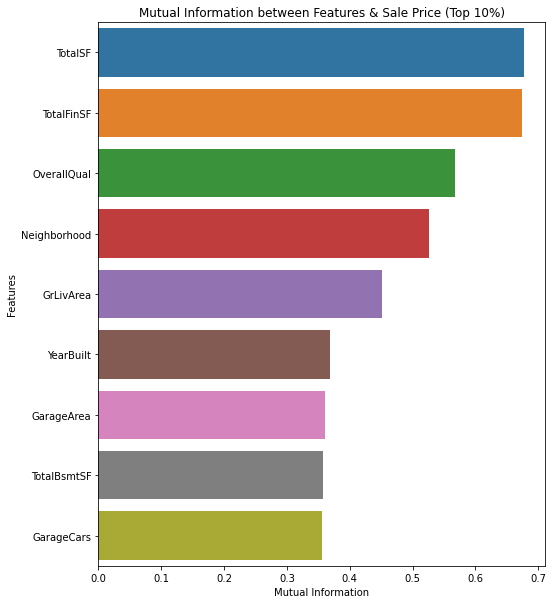

In [635]:
data_tree = mutual_info_tree.sort_values(ascending=False)[0:(int(0.1*len(mutual_info_tree)))]

plt.figure(figsize=(8,10))
plot = sns.barplot(x = data_tree, y = data_tree.index)

plot.set_xlabel("Mutual Information")
plot.set_ylabel("Features")
plot.set_title("Mutual Information between Features & Sale Price (Top 10%)")
fig.tight_layout()

plt.savefig("./graphics/bar_mutual_information.png")

The cumulative distribution of the feature's mutual information. I selected the top 10, 20, and 35% of features to test the models with, as well as all non-zero features and the full set. These 5 sets of data are used below to train models. 

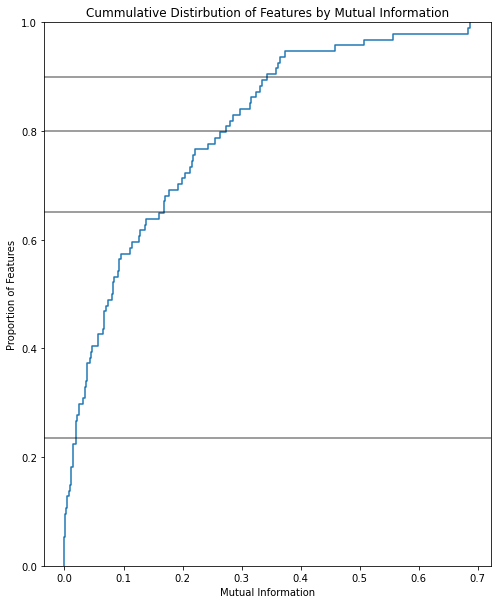

In [289]:
plt.figure(figsize=(8,10))
plot = sns.ecdfplot(data = mutual_info_tree,x = mutual_info_tree,complementary=False)
plot.set_xlabel("Mutual Information")
plot.set_ylabel("Proportion of Features")
plot.set_title("Cummulative Distirbution of Features by Mutual Information")
plot.axhline(y = 0.90, c = 'k', alpha = 0.5)
plot.axhline(y = 0.80, c = 'k', alpha = 0.5)
plot.axhline(y = 0.65, c = 'k', alpha = 0.5)
plot.axhline(y = 0.235, c = 'k', alpha = 0.5)

plt.savefig('./graphics/cummulative_mutual_info.png')


In [636]:
# Using Mutual Information get the k best columns 
top35_lm = SelectPercentile(mutual_info_regression, percentile=35).fit(train_lm,target).get_support()
top20_lm  = SelectPercentile(mutual_info_regression, percentile=20).fit(train_lm,target).get_support()
top10_lm  = SelectPercentile(mutual_info_regression, percentile=10).fit(train_lm,target).get_support()
non_0_lm  = mutual_info_lm[mutual_info_lm != 0].index

top35_tree = SelectPercentile(mutual_info_regression, percentile=35).fit(train_tree,target).get_support()
top20_tree  = SelectPercentile(mutual_info_regression, percentile=20).fit(train_tree,target).get_support()
top10_tree  = SelectPercentile(mutual_info_regression, percentile=10).fit(train_tree,target).get_support()
non_0_tree  = mutual_info_tree[mutual_info_tree != 0].index

full_mi_lm   = train_lm                          # 266 Features
non0_mi_lm   = train_lm[non_0_lm]                # 210 Features
top35_mi_lm  = train_lm.loc[:,top35_lm]          # 93 Features
top20_mi_lm  = train_lm.loc[:,top20_lm]          # 53 Features
top10_mi_lm  = train_lm.loc[:,top10_lm]          # 27 Features

full_mi_tree   = train_tree                      # 96 Features
non0_mi_tree   = train_tree[non_0_tree]          # 84 Features
top35_mi_tree  = train_tree.loc[:,top35_tree]    # 34 Features
top20_mi_tree  = train_tree.loc[:,top20_tree]    # 19 Features
top10_mi_tree  = train_tree.loc[:,top10_tree]    # 10 Features

# Modeling Creation <a id='modeling'></a>

[Back to Top](#top)

Below I use the feature sets generated above to 

Models to examine:

Linear
- Ridge & Lasso MLR
- Elastic Net MLR
- SVR

Tree Based
- Regression Random Forest
- Gradient Boost
- XGBoost


In [637]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

Train & Validation Split. Train indexes will be used to select hyperparameters, Validation score will be used to compare across feature sets and models. 

In [638]:
train_idx, valid_idx = train_test_split(train.index, test_size=0.333)

The function below fits the supplied gridsearchCV model, to each of the feature lists then extracts the scores, parameters, and validation set score. These results are concatenated and appended to a dataframe which is returned.

In [641]:
def cv_fit_extract(model, data_set,names):
    summary  = pd.DataFrame()
    score_id = ['split{}_test_score'.format(x) for x in range(0,5)]
    
    for data,name in zip(data_set,names):

        model.fit(X = data.loc[train_idx],
                #y = target_norm[train_idx].ravel())
                  y=target_log[train_idx].ravel())

        best_index = model.best_index_
        test_score = [model.cv_results_[x][best_index] for x in score_id]
        best_param = model.best_params_
        vali_score = model.score(data.loc[valid_idx], 
                               #target_norm[valid_idx])
                                target_log[valid_idx])

        data_sum   = pd.Series([name, test_score, best_param, vali_score])

        summary = summary.append(data_sum, ignore_index=True)

    summary.columns = ["Feature_Set","Test Scores","Best_Params","Validation Score"]

    return summary

### Models 


In [642]:
# Model instantiations
ridge   = Ridge()
lasso   = Lasso()
elcnt   = ElasticNet()
svr     = SVR()
ran_for = RandomForestRegressor(n_jobs = -1)
grd_bst = GradientBoostingRegressor(verbose=1)
xgboost = XGBRegressor()

# Creating and Packaging Parameters
RD_params = [{'alpha': np.logspace(-5, 3, 50)}]
LO_params = [{'alpha': np.logspace(-5, 0, 50)}]
EN_params = [{'alpha': np.logspace(-10, 3, 20), 
              'l1_ratio': np.linspace(0, 1, 11)}]
SV_params = [{'kernel':['linear','rbf'],
              'gamma': np.logspace(-3,0,4),
              'C': np.logspace(-2,2,4)}]
RF_params = {'n_estimators':np.linspace(20,1000, 5, dtype = int),
             'max_features': ['auto','sqrt'],
             'max_depth': np.linspace(5,50,5,dtype=int).tolist()+["None"], 
             'min_samples_split': [5,10],
             'min_samples_leaf':[2,4,6]}
GB_params = {'max_depth': np.linspace(2,6,3, dtype = int),
             'n_estimators': np.linspace(20,1000,5, dtype = int),
             'min_samples_split': np.linspace(2,6,3, dtype = int),
             'min_samples_leaf': [2,4,6],
             'learning_rate': [0.1,0.05,0.01],
             'subsample': np.linspace(0.65,0.75,3)}
XG_params = {'learning_rate': [0.001, 0.01, 0.3, 0.5],
             'gamma': np.logspace(-2,3,6).tolist()+[0],
             'max_depth': np.linspace(2,10,5, dtype=int),
             'subsample': [0.5,0.75,1],
             'min_child_weight': [4,8,12]}

# Grid Search functions
#  log-RMSE is what Kaggle uses, function uses negative because 'maximizing'
cvR  = GridSearchCV(ridge,   RD_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvL  = GridSearchCV(lasso,   LO_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvEN = GridSearchCV(elcnt,   EN_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvSV = GridSearchCV(svr,     SV_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvRF = GridSearchCV(ran_for, RF_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvGB = GridSearchCV(grd_bst, GB_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)
cvXG = GridSearchCV(xgboost, XG_params, scoring = 'neg_root_mean_squared_error', verbose = 1, n_jobs=-1)

In [643]:
# these need to be updated with tree model.
lm_data_set = [full_mi_lm, non0_mi_lm, top35_mi_lm, top20_mi_lm, top10_mi_lm]
tree_data_set = [full_mi_tree, non0_mi_tree, top35_mi_tree, top20_mi_tree, top10_mi_tree]
names    = ["full_mi", "non0_mi", "top35_mi", "top20_mi", "top10_mi"]


lasso_results = cv_fit_extract(cvL,  lm_data_set, names)  # fast
ridge_results = cv_fit_extract(cvR,  lm_data_set, names)  # fast
elnet_results = cv_fit_extract(cvEN, lm_data_set, names)  # fast
svr_results   = cv_fit_extract(cvSV, lm_data_set, names)  # 1 hour run time on 6 core CPU
RF_results    = cv_fit_extract(cvRF, tree_data_set, names)  # 6 hour run time on 6 core CPU
GB_results    = cv_fit_extract(cvGB, tree_data_set, names)  # ~15 min
XG_results    = cv_fit_extract(cvXG, tree_data_set, names)  # 1 hour run time on 6 core CPU

lasso_results['Model'] = (["Lasso"]*5)
ridge_results['Model'] = (["Ridge"]*5)
elnet_results['Model'] = (["ElasticNet"]*5)
svr_results['Model']   = (["SVR"]*5)
RF_results['Model']    = (["RandomForest"]*5)
GB_results['Model']    = (["GradientBoost"]*5)
XG_results['Model']    = (['XGBoost']*5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fit

C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15180685 -0.14838689 -0.14841863 -0.14836804 -0.14832282 -0.1508368
 -0.14894193 -0.14884432 -0.14865078 -0.1486448  -0.15096317 -0.14760903
 -0.14778724 -0.14800992 -0.14777821 -0.15268357 -0.14773676 -0.14801944
 -0.14827889 -0.14809828 -0.15009467 -0.14837275 -0.14814974 -0.14862522
 -0.14827332 -0.14961837 -0.1489793  -0.14857677 -0.14832955 -0.1481968
 -0.15625111 -0.1495231  -0.15011503 -0.1494788  -0.14929229 -0.15328237
 -0.14997136 -0.14927589 -0.14994945 -0.14962687 -0.15445222 -0.15051475
 -0.14960628 -0.15003463 -0.14994756 -0.15276207 -0.15000155 -0.15076329
 -0.14973227 -0.14970709 -0.15295768 -0.15155216 -0.15093018 -0.15091146
 -0.15108008 -0.15454984 -0.15088098 -0.15097931 -0.15032244 -0.15066973
 -0.14070298 -0.13590237 -0.13584172 -0.13575764 -0.13552408 -0.14152826
 -0.13765203 -0.13679088 -0.1373438  -0.13686202 -0.1408

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15214537 -0.14782994 -0.14868617 -0.14760263 -0.14791505 -0.15072157
 -0.14931614 -0.14837068 -0.14821843 -0.14832803 -0.15040651 -0.14810958
 -0.14804394 -0.14742639 -0.14759875 -0.14885487 -0.14781386 -0.14816369
 -0.14789753 -0.14812395 -0.15260899 -0.14788261 -0.14768524 -0.14802644
 -0.14805734 -0.14906734 -0.14828456 -0.14816566 -0.14775452 -0.14796831
 -0.15152968 -0.14895817 -0.14860861 -0.14868584 -0.14819664 -0.15415318
 -0.14884294 -0.14867669 -0.14886194 -0.14936993 -0.15302068 -0.14807367
 -0.14868889 -0.14878876 -0.14900618 -0.15272492 -0.14919689 -0.14920284
 -0.14911083 -0.14903433 -0.15343243 -0.14965468 -0.15005558 -0.15026435
 -0.14958382 -0.15651797 -0.15081416 -0.14986941 -0.14946617 -0.14965556
 -0.13842066 -0.13522686 -0.13507399 -0.13525923 -0.13490856 -0.14014234
 -0.13759962 -0.13706787 -0.13660656 -0.13657362 -0.13

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15448    -0.15199367 -0.15188368 -0.15222616 -0.15203957 -0.15458801
 -0.15258872 -0.15193499 -0.15257967 -0.15234669 -0.15340849 -0.15235342
 -0.15205221 -0.15183196 -0.15247869 -0.15599807 -0.15253384 -0.15238094
 -0.15250788 -0.15237338 -0.15555542 -0.15253868 -0.15255931 -0.15227386
 -0.1525127  -0.15459113 -0.15270649 -0.15291049 -0.15264697 -0.15245417
 -0.15097933 -0.14800288 -0.14815077 -0.14802302 -0.14763297 -0.15391464
 -0.14832546 -0.14821834 -0.14792433 -0.14833557 -0.15421256 -0.14869144
 -0.14852522 -0.14838398 -0.14833926 -0.15169853 -0.14878582 -0.14825665
 -0.14856528 -0.14825197 -0.15204789 -0.14911499 -0.14864988 -0.14884343
 -0.14892352 -0.15091281 -0.14927276 -0.14971973 -0.14907732 -0.14935071
 -0.14412948 -0.14195357 -0.14121497 -0.14105647 -0.14113003 -0.14402595
 -0.14263141 -0.14258522 -0.14195813 -0.14232078 -0.14

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15678566 -0.15354088 -0.15392977 -0.15360979 -0.15396625 -0.15398051
 -0.15418671 -0.15413541 -0.15383457 -0.15412145 -0.15743453 -0.15419674
 -0.15457158 -0.15441261 -0.15451613 -0.15609727 -0.15503354 -0.15484418
 -0.15484809 -0.15432112 -0.15656267 -0.15547019 -0.15513638 -0.15533376
 -0.15498093 -0.15823022 -0.15463988 -0.15495602 -0.15508768 -0.15517094
 -0.15472984 -0.15047591 -0.14990972 -0.15001575 -0.15002983 -0.15258211
 -0.15023513 -0.14955754 -0.15002759 -0.15039407 -0.15376341 -0.15126854
 -0.15042228 -0.15039132 -0.15070488 -0.15245909 -0.15051094 -0.15077444
 -0.15095214 -0.15079056 -0.15614552 -0.15153412 -0.15184322 -0.15152461
 -0.15145379 -0.15325968 -0.15173108 -0.15117448 -0.15129632 -0.15123171
 -0.1470233  -0.14563086 -0.14562394 -0.14580191 -0.14498929 -0.14919224
 -0.14667317 -0.14681408 -0.14662873 -0.14618583 -0.15

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\James\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15826188 -0.15725116 -0.15670571 -0.1568707  -0.15656514 -0.1596484
 -0.15791029 -0.15711088 -0.15712193 -0.15708219 -0.16013629 -0.1578293
 -0.15815571 -0.15787232 -0.15810992 -0.15817459 -0.15861453 -0.15794366
 -0.15835648 -0.15793707 -0.16081232 -0.15789725 -0.15840658 -0.15831749
 -0.15863151 -0.16032313 -0.15830437 -0.15801473 -0.15837302 -0.15832857
 -0.15665715 -0.15503377 -0.15439705 -0.15440278 -0.1545551  -0.1556537
 -0.15500188 -0.15446513 -0.15492661 -0.15483395 -0.15802583 -0.15545899
 -0.15561229 -0.15584805 -0.15556829 -0.15826126 -0.15536757 -0.1554126
 -0.15556838 -0.1556476  -0.15686908 -0.15583317 -0.15558107 -0.15630016
 -0.15618246 -0.15911567 -0.15559706 -0.156178   -0.15586817 -0.15610894
 -0.15331889 -0.15128469 -0.15161707 -0.15154429 -0.15118953 -0.1569852
 -0.15210987 -0.15164708 -0.15146441 -0.15169899 -0.1546781

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1390           0.0214            0.79s
         2           0.1186           0.0172            0.66s
         3           0.1150           0.0135            0.61s
         4           0.0974           0.0125            0.65s
         5           0.0886           0.0104            0.62s
         6           0.0803           0.0089            0.60s
         7           0.0703           0.0078            0.59s
         8           0.0607           0.0063            0.61s
         9           0.0542           0.0062            0.60s
        10           0.0478           0.0051            0.59s
        20           0.0255           0.0013            0.55s
        30           0.0175           0.0004            0.52s
        40           0.0137           0.0001            0.49s
        50           0.0109          -0.0000            0.46s
    

# Model Comparison <a id ="compare"></a>
[Back to Top](#top)

#### Checkpoint: Model Comparison Import

The below chunck checks if the above chunks have been run, if they have not (because it takes a while), an exception will be raised and the csv file will be read in from the directory.

In [674]:
import ast

try:
    cv_results = pd.concat([lasso_results, ridge_results, elnet_results, 
                            svr_results, RF_results, GB_results, XG_results,
                            XXXXX]) # This will force loading from file
                           #])
                            
    print("Saving Model Benchmarks")
    cv_results.to_csv("./cv_hyperparameter_results.csv", index=False)
    
except:
    cv_results = pd.read_csv("./cv_hyperparameter_results.csv")
    print("Importing Previous Model Benchmarks")
    
    # Trouble with Saving Lists/Dicts, cleaning data.
    cv_results['Best_Params'] = [ast.literal_eval(x) for x in cv_results['Best_Params']]
    cv_results['Test Scores'] = [ast.literal_eval(x) for x in cv_results['Test Scores']]

Importing Previous Model Benchmarks


This chuck prepares the cv_results by pivoting the Test and validation scores into one column as well as adding some columns which allow better graphing.

In [675]:
# Seperate Train values from Validation scores
cv_results_train =  cv_results.filter(['index','Feature_Set','Test Scores','Best_Params','Model'],axis =1
                     ).explode('Test Scores'
                      ).melt(id_vars    = ['Feature_Set','Best_Params','Model'],
                             value_vars =['Test Scores'],
                             var_name   ='Score_Type',
                             value_name = 'Neg_RMSE')

# Seperate validation scores from train data
cv_results_valid = cv_results.filter(['index','Feature_Set','Validation Score','Best_Params','Model'],axis =1
                            ).melt(id_vars    = ['Feature_Set','Best_Params','Model'],
                                 value_vars =['Validation Score'],
                                 var_name   ='Score_Type',
                                 value_name = 'Neg_RMSE')

# Combine Trian & Validation without introducing duplicates
cv_results = pd.concat([cv_results_valid,cv_results_train]).rename(columns={'index':"Split"})

mi_to_string = {"full_mi": 'All Features' , "non0_mi":'Non-Zero MI', "top35_mi":'Top 35%', "top20_mi":'Top 20%', "top10_mi":'Top 10%'}
mi_to_number = {"top10_mi":28, "top20_mi":55, "top35_mi":97,  "non0_mi":213,"full_mi": 276 }
cv_results['Number of Features'] = cv_results['Feature_Set'].replace(mi_to_string)
cv_results['nFeatures'] = cv_results['Feature_Set'].replace(mi_to_number)
cv_results['Score_Type'] = cv_results["Score_Type"].replace({"Test Scores": "Cross-Validation Scores","Validation Scores":"Test Scores"})
cv_results['Neg_RMSE'] = (cv_results['Neg_RMSE']*-1)


The grid of each model & feature sets performance as measured by the negative log RMSE of sale-price. The value is negative due to the maximizing function of GridSearchCV and the log-RMSE is the same metric used by the Kaggle competition.

For most models, and feature sets, the validation score is within the Test Scores from the cross validation. An excellent signal that overfitting was avoided. The RandomForest, GraidentBoost and XGBoost models show the interesting phenomena of the validation scores being at the upper end or higher than the cross-validaiton test scores. This indicates that there is a lower error in our out of 'train-set' and will hopefully hold up in the test dataset included with the submission. 

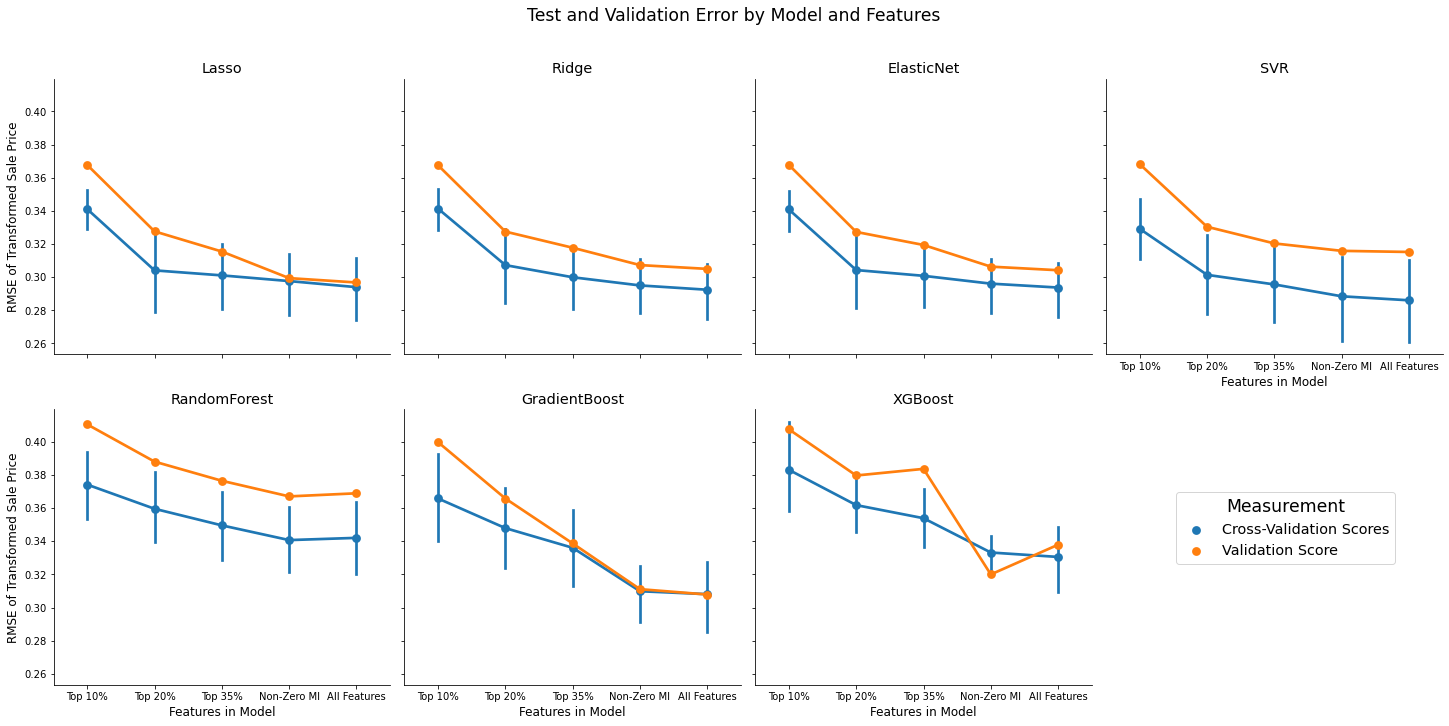

In [677]:
plot = sns.catplot(x ='Number of Features', 
                   y = 'Neg_RMSE',
                   data = cv_results.sort_values('nFeatures'),
                   hue = 'Score_Type',
                   col = 'Model',
                   col_wrap= 4,
                   col_order=['Lasso','Ridge','ElasticNet','SVR','RandomForest','GradientBoost','XGBoost'],
                   kind = 'point',
                   legend = False)

plt.subplots_adjust(hspace = 0.2)

plot.set_titles(col_template='{col_name}',size='x-large')
plot.set_axis_labels("Features in Model","RMSE of Transformed Sale Price", fontsize= 'large')

plot.fig.subplots_adjust(top=0.88)
plot.fig.suptitle('Test and Validation Error by Model and Features',fontsize = 'xx-large')

plt.legend(title = 'Measurement', 
           bbox_to_anchor=(1.25, 0.7),
           loc=2, 
           borderaxespad=0.,
           fontsize = 'x-large',
           title_fontsize = 'xx-large')

plot.savefig("./graphics/test_val_RMSE.png")

The top 10 resutls are mostly RandomForest, SVR, and the last two are from gradient boost. We do observe that across samples, the fewer feature datasets produce models with worse RMSE compared to models with more features (ie. information). 

In [716]:
cv_results[cv_results.Score_Type == 'Validation Score'].sort_values('Neg_RMSE', ascending = True).head(10)

Feature_Set                                        Best_Params  \
0      full_mi                    {'alpha': 0.001757510624854793}   
1      non0_mi                   {'alpha': 0.0013894954943731374}   
10     full_mi    {'alpha': 0.01623776739188724, 'l1_ratio': 0.0}   
5      full_mi                       {'alpha': 23.29951810515367}   
11     non0_mi    {'alpha': 0.01623776739188724, 'l1_ratio': 0.0}   
6      non0_mi                       {'alpha': 23.29951810515367}   
25     full_mi  {'learning_rate': 0.05, 'max_depth': 2, 'min_s...   
26     non0_mi  {'learning_rate': 0.05, 'max_depth': 2, 'min_s...   
15     full_mi  {'C': 4.6415888336127775, 'gamma': 0.001, 'ker...   
2     top35_mi                    {'alpha': 0.001757510624854793}   

            Model        Score_Type  Neg_RMSE Number of Features  nFeatures  
0           Lasso  Validation Score   0.29678       All Features        276  
1           Lasso  Validation Score  0.299404        Non-Zero MI        213  
10     ElasticNet  Validation Score  0.304171       All Features        276  
5           Ridge  Validation Score  0.304983       All Features        276  
11     ElasticNet  Validation Score  0.306332        Non-Zero MI        213  
6           Ridge  Validation Score  0.307268        Non-Zero MI        213  
25  GradientBoost  Validation Score  0.307876       All Features        276  
26  GradientBoost  Validation Score  0.311104        Non-Zero MI        213  
15            SVR  Validation Score  0.315187       All Features        276  
2           Lasso  Validation Score  0.315437            Top 35%         97

# Model Analysis <a id = "analysis"></a>
[Back to Top](#top)

While model performance is more error prone than expected, we still want to know what it can tell us about housing prices and features.

Below the best hyperparameters of the linear and Tree based models are re fitted with the train data. We see that the train partition has a slightly better score but the Validation score remains the same as we observed above (as expected).

The Actual vs Predicted & Actual vs Residuals plots reveal that the models have moderate error along low-middle priced houses. However both models begin to diverge when predicting the prices of homes which sold more

In [707]:
# Extracting models
best_LO_params = cv_results[(cv_results.Feature_Set == "full_mi") & (
                             cv_results.Model == 'Lasso') & (
                             cv_results.Score_Type == "Validation Score")]['Best_Params'].values[0]

best_GB_params = cv_results[(cv_results.Feature_Set == "full_mi") & (
                             cv_results.Model == 'GradientBoost') & (
                             cv_results.Score_Type == "Validation Score")]['Best_Params'].values[0]

best_lasso = Lasso()
best_lasso.set_params(**best_LO_params)
best_gdbst = GradientBoostingRegressor()
best_gdbst.set_params(**best_GB_params)


best_lasso.fit(full_mi_lm.loc[train_idx],target_norm[train_idx].ravel())
best_gdbst.fit(full_mi_tree.loc[train_idx],target_norm[train_idx].ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=755,
                          subsample=0.65)

In [708]:
def return_rmse(model, X, y_actual, transformer = None, log = False):
    y_pred = model.predict(X)
    if transformer is not None:
        y_pred   = transformer.inverse_transform(y_pred.reshape(-1,1))
        y_actual = transformer.inverse_transform(y_actual)
    if log:
        y_pred   = np.log(y_pred)
        y_actual = np.log(y_actual)
    return mean_squared_error(y_actual, y_pred, squared=False)


In [717]:
models = [best_lasso, best_gdbst]
dataset = [full_mi_lm, full_mi_tree]
name = ["Lasso","Gradient Boost"]
for idx in [0,1]:
    print("*"*55)
    print(name[idx])
    print("Train Score: RMSE adjusted-SalePrice: {:.2}".format(return_rmse(models[idx],
                                                                       dataset[idx].loc[train_idx], 
                                                                       target_norm[train_idx])))
    print("Train Score: RMSE USD: {:.2f}".format(return_rmse(models[idx],
                                                            dataset[idx].loc[train_idx],
                                                            target_norm[train_idx],
                                                            transformer=target_tran)))
    print("Validation Score: RMSE adjusted-SalePrice: {:.2f}".format(return_rmse(models[idx],
                                                                           dataset[idx].loc[valid_idx], 
                                                                           target_norm[valid_idx])))
    print("Validation Score: RMSE USD: {:.2f}".format(return_rmse(models[idx],
                                                                 dataset[idx].loc[valid_idx], 
                                                                 target_norm[valid_idx], 
                                                                 transformer=target_tran)))

    print("Validation Score: RMS-log-E USD: {:.2f}".format(return_rmse(models[idx],
                                                                 dataset[idx].loc[valid_idx], 
                                                                 target_norm[valid_idx], 
                                                                 transformer=target_tran,
                                                                 log = True)))

*******************************************************
Lasso
Train Score: RMSE adjusted-SalePrice: 0.24
Train Score: RMSE USD: 18224.86
Validation Score: RMSE adjusted-SalePrice: 0.30
Validation Score: RMSE USD: 20663.40
Validation Score: RMS-log-E USD: 0.12
*******************************************************
Gradient Boost
Train Score: RMSE adjusted-SalePrice: 0.15
Train Score: RMSE USD: 10887.61
Validation Score: RMSE adjusted-SalePrice: 0.31
Validation Score: RMSE USD: 21504.09
Validation Score: RMS-log-E USD: 0.12


### Kaggle?

In [532]:
# Test Data was already encoded & transformed
test_lm
test_tree

# Slight data update
test_lm['Exterior_Other'] = [0]*test_lm.shape[0]

# predict & package
lasso_test_predict = target_tran.inverse_transform(best_lasso.predict(test_lm).reshape(-1,1)).ravel().tolist()
gdbst_test_predict = target_tran.inverse_transform(best_gdbst.predict(test_tree).reshape(-1,1)).ravel().tolist()


cols = ["Id","SalePrice"]
lasso_test_predict = pd.DataFrame(zip(test_ID,  lasso_test_predict),  columns = cols)
gdbst_test_predict = pd.DataFrame(zip(test_ID, gdbst_test_predict), columns = cols)


# Saving File
lasso_test_predict.to_csv("./lasso_submission.csv",index=False)
gdbst_test_predict.to_csv("./gdbst_submission.csv",index=False)

In [534]:
# Submitting to Kaggle
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f lasso_submission.csv -m "Lasso Model 20210825"
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f gdbst_submission.csv -m "GradientBoost Model 20210825"


Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.0k [00:00<?, ?B/s]
100%|##########| 35.0k/35.0k [00:00<00:00, 97.9kB/s]


Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/35.1k [00:00<?, ?B/s]
100%|##########| 35.1k/35.1k [00:00<00:00, 98.9kB/s]


In [536]:
!kaggle competitions submissions -c house-prices-advanced-regression-techniques

fileName              date                 description                   status    publicScore  privateScore  
--------------------  -------------------  ----------------------------  --------  -----------  ------------  
gdbst_submission.csv  2021-08-25 21:49:31  GradientBoost Model 20210825  complete  0.13560      None          
lasso_submission.csv  2021-08-25 21:49:27  Lasso Model 20210825          complete  0.21040      None          
gdbst_submission.csv  2021-08-25 21:45:46  GradientBoost Model 20210825  error     None         None          
lasso_submission.csv  2021-08-25 21:45:45  Lasso Model 20210825          error     None         None          
gdbst_submission.csv  2021-08-25 21:45:27  GradientBoost Model 20210825  error     None         None          
lasso_submission.csv  2021-08-25 21:45:25  Lasso Model 20210825          error     None         None          
gdbst_submission.csv  2021-08-25 21:42:49  GradientBoost Model 20210825  error     None         None          
l

#### Kaggle Results

|Model | RMSE|
|----|-----|
|Lasso| 0.21040 |
|Gradient Boost | 0.13560|

### Model Performance

asdfdskal;fjsdka;ljfdsa;kfjldsafds

In [710]:
#Model Residuals

original_usd = target_tran.inverse_transform(target_norm).ravel().tolist()
Lasso_prediction  = target_tran.inverse_transform(best_lasso.predict(full_mi_lm).reshape(-1,1)).ravel().tolist()
GradientBoost_prediction = target_tran.inverse_transform(best_gdbst.predict(full_mi_tree).reshape(-1,1)).ravel().tolist()
lasso_label  = ["Lasso Prediction"]*len(original_usd)
grdbst_label = ["GradientBoost Prediction"]*len(original_usd)



model_predictions = pd.DataFrame(list(zip(lasso_label,original_usd,Lasso_prediction)) +
                                 list(zip(grdbst_label,original_usd,GradientBoost_prediction)),
                                 columns=["Model","Actual Price","Predicted Price"])

model_predictions["Residuals"] = model_predictions["Predicted Price"] - model_predictions["Actual Price"]


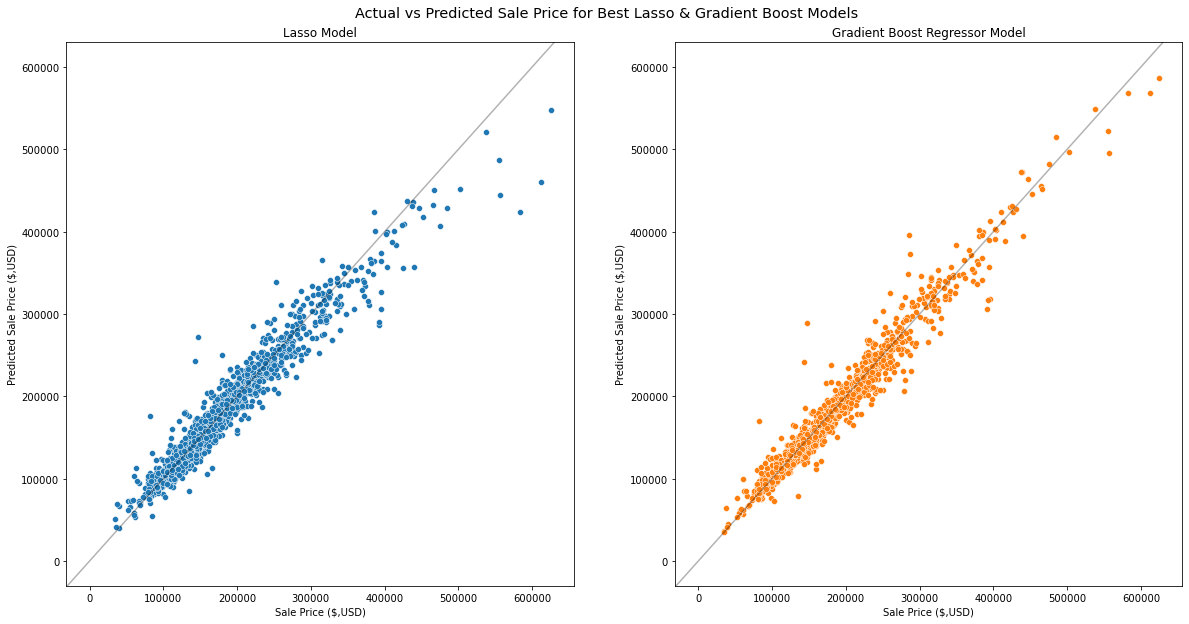

In [711]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plot_titles = ["Lasso Model",'Gradient Boost Regressor Model']
plot_colors = sns.color_palette()
sns.scatterplot(x="Actual Price",
                y="Predicted Price",
                data = model_predictions[model_predictions['Model']=="Lasso Prediction"],
                color=plot_colors[0],
                ax=ax[0])
sns.scatterplot(x="Actual Price",
                y="Predicted Price",
                data = model_predictions[model_predictions['Model']=="GradientBoost Prediction"], 
                color=plot_colors[1],
                ax=ax[1])

for idx, axis in enumerate(ax):
    ax[idx].axline((0,0),(6e5,6e5),c='k',alpha=0.3)
    ax[idx].set_title(plot_titles[idx])
    ax[idx].set_ylabel("Predicted Sale Price ($,USD)")
    ax[idx].set_xlabel("Sale Price ($,USD)")
    
plt.suptitle("Actual vs Predicted Sale Price for Best Lasso & Gradient Boost Models",y=0.93,fontsize='x-large')    
plt.savefig("./graphics/actual_vs_pred.png")

Text(0.5, 0.93, 'Residuals vs Actual Sale Price for Best Lasso & Gradient Boost Models')

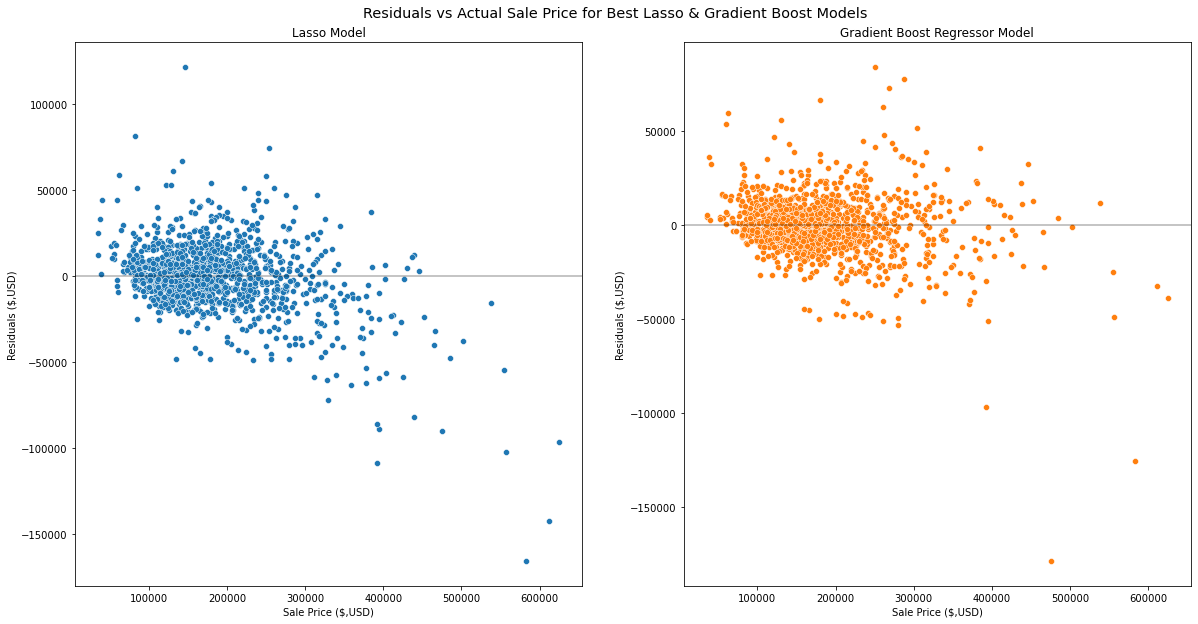

In [700]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plot_titles = ["Lasso Model",'Gradient Boost Regressor Model']
plot_colors = sns.color_palette()
sns.scatterplot(x="Actual Price",
                y="Residuals",
                data = model_predictions[model_predictions['Model']=="Lasso Prediction"],
                color=plot_colors[0],
                ax=ax[0])
sns.scatterplot(x="Actual Price",
                y="Residuals",
                data = model_predictions[model_predictions['Model']=="GradientBoost Prediction"], 
                color=plot_colors[1],
                ax=ax[1])

for idx, axis in enumerate(ax):
    ax[idx].axhline(y=0,c='k',alpha=0.3)
    ax[idx].set_title(plot_titles[idx])
    ax[idx].set_ylabel("Residuals ($,USD)")
    ax[idx].set_xlabel("Sale Price ($,USD)")

#ax[0].axhline(y= 20700)
#ax[0].axhline(y=-20700)

#ax[1].axhline(y= 21500)
#ax[1].axhline(y=-21500)



plt.suptitle("Residuals vs Actual Sale Price for Best Lasso & Gradient Boost Models",y=0.93,fontsize='x-large')    
#plt.savefig("./graphics/actual_vs_residuals.png")

#### Feature Importance

In [718]:
lasso_importance = pd.Series(index=full_mi_lm.columns,data=best_lasso.coef_)

gdbst_importance = pd.Series(index=full_mi_tree.columns,data = best_gdbst.feature_importances_)


In [719]:
def plot_importance(data, x_axis):
    data = data.sort_values(ascending=False, key=abs)[0:20]
    plot = sns.barplot(y=data.index, x=data, orient='h')
    plot.set_xlabel(x_axis)
    return plot

C:\Users\James\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3179: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


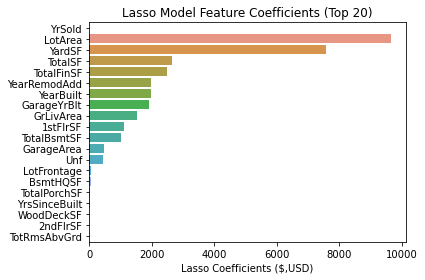

In [714]:
inv_transform = pd.Series(index=numerical_cols,
                          data= Norm_enc.inverse_transform(lasso_importance[numerical_cols].to_numpy().reshape(1,-1)).ravel())

lasso_importance_adj = lasso_importance.drop(index=numerical_cols)
lasso_importance_adj = lasso_importance_adj.append(inv_transform)

#plot = plot_importance(lasso_importance,'Lasso Coefficients')
plot = plot_importance(lasso_importance_adj,'Lasso Coefficients ($,USD)')

plot.set_title("Lasso Model Feature Coefficients (Top 20)")
plt.tight_layout()
plt.savefig("./graphics/lasso_feature_importance.png")

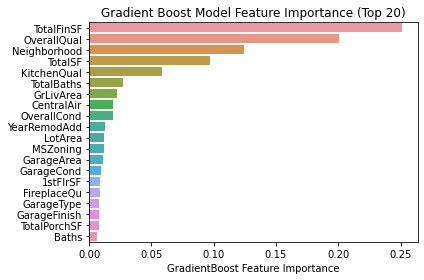

In [720]:
plot = plot_importance(gdbst_importance,'GradientBoost Feature Importance')
plot.set_title("Gradient Boost Model Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("./graphics/grdbst_feature_importance.png")

In [721]:
[print(x) for x in gdbst_importance.sort_values(ascending=False).index]

TotalFinSF
OverallQual
Neighborhood
TotalSF
KitchenQual
TotalBaths
GrLivArea
CentralAir
OverallCond
YearRemodAdd
LotArea
MSZoning
GarageArea
GarageCond
1stFlrSF
FireplaceQu
GarageType
GarageFinish
TotalPorchSF
Baths
GarageYrBlt
Unf
GLQ
SaleCondition
YardSF
ExterCond
LowQualFinSF
YrsSinceBuilt
GarageCars
MSSubClass
BsmtQual
Condition1
YearBuilt
BsmtPercFin
SaleType
TotalBsmtSF
Functional
MoSold
BsmtExposure
WoodDeckSF
HeatingQC
BsmtCond
BsmtHQSF
LotFrontage
PavedDrive
LandContour
Rec
LwQ
2ndFlrSF
PorchType
TotalFullBaths
RoofStyle
BLQ
ALQ
BedroomAbvGr
MasVnrArea
LotConfig
Foundation
Exterior2nd
TotRmsAbvGrd
Exterior1st
KitchenAbvGr
Fireplaces
GarageQual
Alley
Fence
HouseStyle
YrSold
BsmtFullBath
Electrical
FullBath
PoolQC
RoofMatl
BsmtFull
PoolArea
LandSlope
MasVnrType
HalfBath
MiscVal
Floors
TotalHalfBaths
ExterQual
Condition2
LotShape
Remodeled
MiscFeature
BsmtMixed
BsmtHalfBath
BldgType
None
RecentTaste
Utilities
Street
HasPool
Heating


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Unimportant Features

In [357]:
lasso_importance[lasso_importance == 0] # 165 WOW!!!

YearBuilt                  0.0
TotalBsmtSF                0.0
1stFlrSF                  -0.0
2ndFlrSF                   0.0
GarageArea                 0.0
                          ... 
SaleCondition_Family      -0.0
SaleCondition_Partial      0.0
PorchType_3SsnPorch       -0.0
PorchType_EnclosedProch   -0.0
PorchType_Multiple         0.0
Length: 165, dtype: float64

In [351]:
gdbst_importance.sort_values().head(10)

FullBath        0.000000
RecentTaste     0.000000
Street          0.000000
None            0.000000
Utilities       0.000000
MiscFeature     0.000020
Floors          0.000022
BsmtMixed       0.000025
BsmtHalfBath    0.000026
RoofMatl        0.000027
dtype: float64

## Feature Deep Dive

#### Neighborhoods

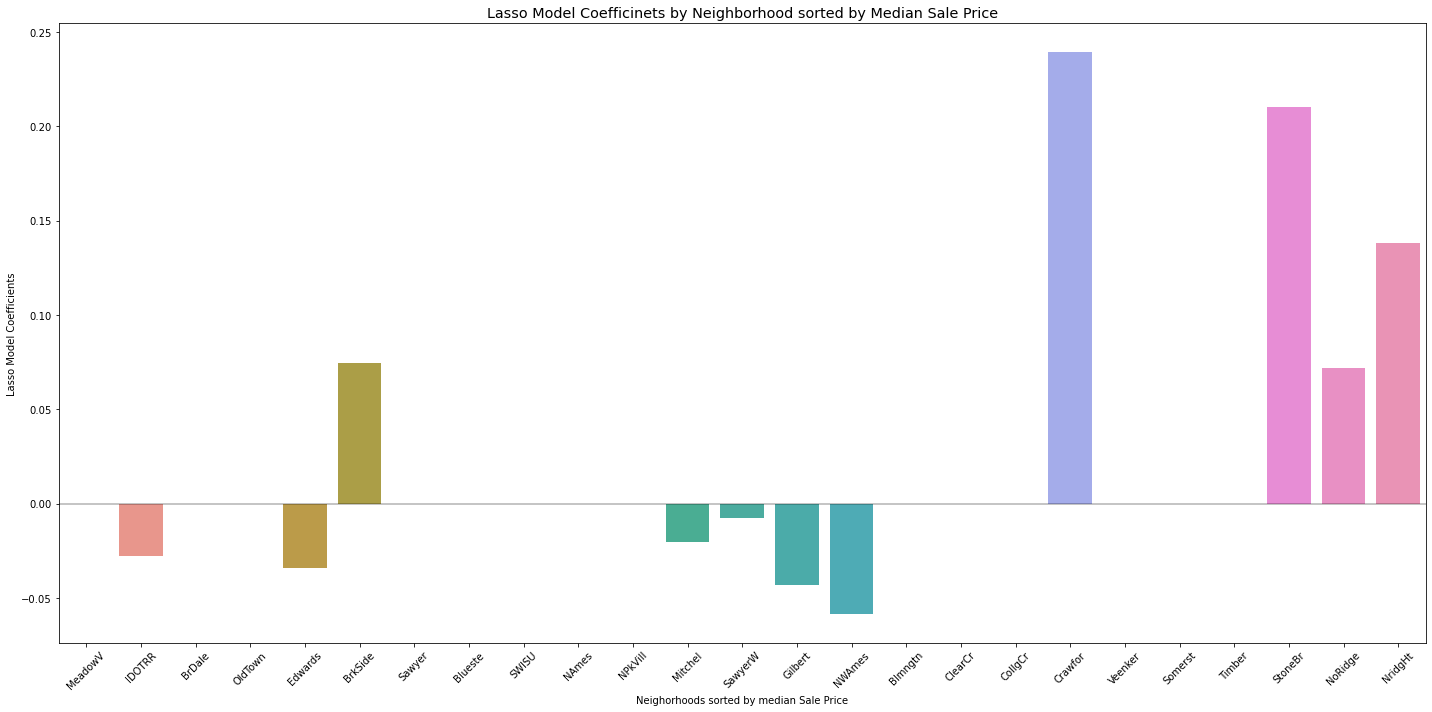

In [540]:
data   = lasso_importance.filter(regex="^Neighborhood_")
labels = [x.replace("Neighborhood_","") for x in data.index]
data   = pd.DataFrame(zip(data, labels),columns =["Coefficient","Neighborhood"])
data['Sale_price_order'] = data.Neighborhood.replace(label_dict['Neighborhood'])
data   = data.sort_values('Sale_price_order')
data['Value_counts'] = data.Neighborhood.replace(dict(train.Neighborhood.value_counts())) / train.shape[0]



plt.figure(figsize=(20,10))

sns.barplot(x = 'Neighborhood',
            y = "Coefficient",
           data = data)


plt.xticks(rotation = 45)
plt.xlabel("Neighorhoods sorted by median Sale Price")
plt.ylabel("Lasso Model Coefficients")
plt.title("Lasso Model Coefficinets by Neighborhood sorted by Median Sale Price", fontsize = 'x-large')
plt.axhline(y=0,c='k',alpha=0.3)
plt.tight_layout()
plt.savefig("./graphics/neighborhood_coefficients.png")




Text(0.5, 1.0, 'Lasso Model Coefficinets by Neighborhood sorted by Median Sale Price:: Dots are relative Value Counts')

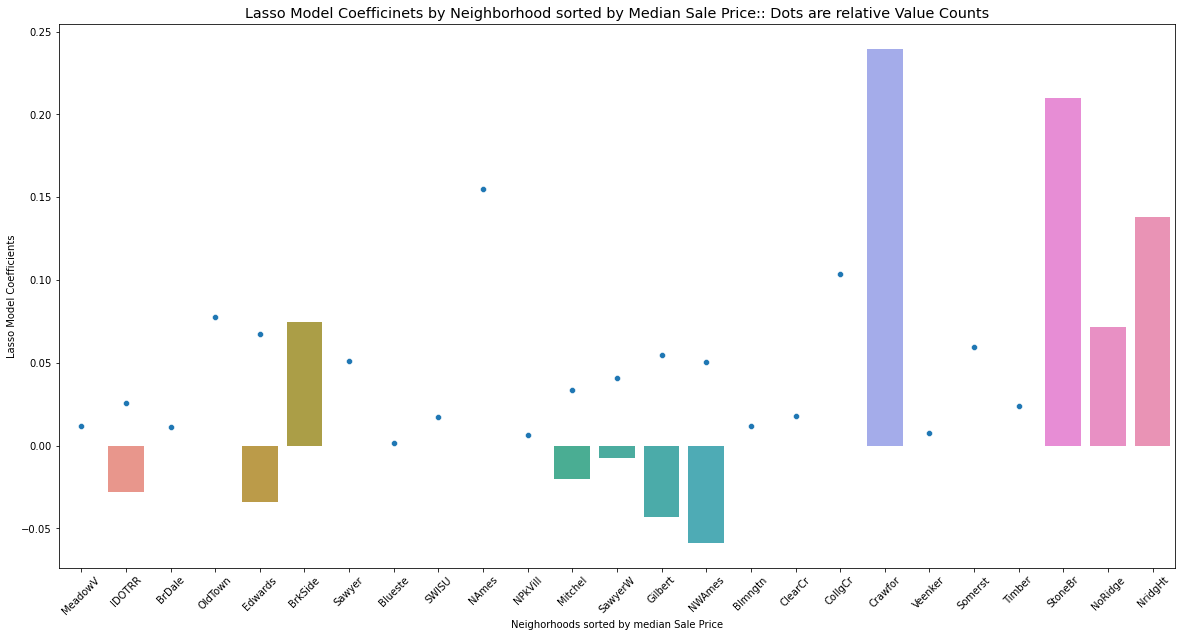

In [465]:
label_dict['Neighborhood']


data   = lasso_importance.filter(regex="^Neighborhood_")
labels = [x.replace("Neighborhood_","") for x in data.index]
data   = pd.DataFrame(zip(data, labels),columns =["Coefficient","Neighborhood"])
data['Sale_price_order'] = data.Neighborhood.replace(label_dict['Neighborhood'])
data   = data.sort_values('Sale_price_order')
data['Value_counts'] = data.Neighborhood.replace(dict(train.Neighborhood.value_counts())) / train.shape[0]



plt.figure(figsize=(20,10))
sns.scatterplot(x='Neighborhood',
               y="Value_counts",
               data = data)

sns.barplot(x = 'Neighborhood',
            y = "Coefficient",
           data = data)


plt.xticks(rotation = 45)
plt.xlabel("Neighorhoods sorted by median Sale Price")
plt.ylabel("Lasso Model Coefficients")
plt.title("Lasso Model Coefficinets by Neighborhood sorted by Median Sale Price:: Dots are relative Value Counts", fontsize = 'x-large')

#plt.savefig("")




#### MSZoning

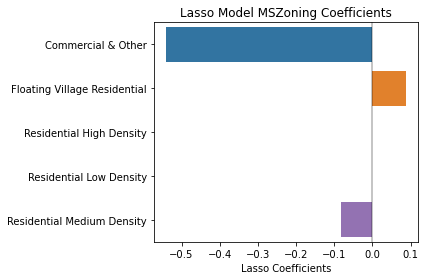

In [541]:
data   = lasso_importance.filter(regex="^MSZoning_")
labels = [x.replace("MSZoning_","") for x in data.index]
data   = pd.DataFrame(zip(data, labels),columns =["Coefficient","MSZoning"])

zoning_dict = {"C (all)":"Commercial & Other",
               "FV":"Floating Village Residential",
               "RH":"Residential High Density",
               "RL":"Residential Low Density",
               "RM":"Residential Medium Density"}

data["MSZoning"] = data["MSZoning"].replace(zoning_dict)

sns.barplot(y="MSZoning",
           x = "Coefficient",
           data = data)
plt.axvline(x=0,c='k',alpha =0.3)
plt.xlabel("Lasso Coefficients")
plt.ylabel("")
plt.title("Lasso Model MSZoning Coefficients")
plt.tight_layout()
plt.savefig("./graphics/zoning_coefficeints.png")

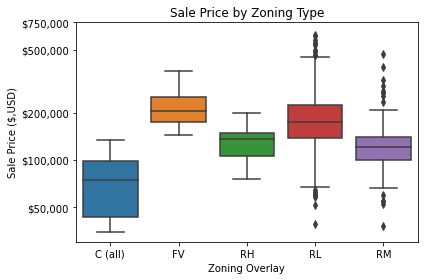

In [543]:
data = train
sns.boxplot(x= train.MSZoning,
           y=np.log(target),
           order = ["C (all)","FV","RH","RL","RM"])

yticks = [50000,100000, 200000, 500000, 750000]
ytick_labels = ["${:,}".format(x) for x in yticks]

plt.yticks(ticks=np.log(yticks),
          labels= ytick_labels)
plt.xlabel("Zoning Overlay")
plt.ylabel("Sale Price ($,USD)")
plt.title("Sale Price by Zoning Type")
plt.tight_layout()
plt.savefig("./graphics/zoning_price.png")

# *FIN*

[Back to Top](#top)